# La modélisation:
> Cette partie du projet se décompose en deux points :

- une concernant la segmentation selon la méthodologie RFM
- la deuxième se concentre sur l'utilisation d'un modèle de clustering et la stabilité temporelle de l'attribution de ces clusters
- La méthode RFM consiste à segmenter notre précédente base de données selon 3 variables ( RFM Segmentation) et à calculer un score pour chaque client. Le score obtenu définie dans quelle catégorie le client appartient. Il existe plusieurs catégories de clients en fonction de leurs comportements d'achat.

- Dans un second, la base de données issue de la précédente partie a été utilisée. Elle a été agrégée par clients uniques en prenant en compte toutes les données pertinentes.

- Etant donné la taille du jeu de données, seulement un échantillon a été étudié. La base de donnée a subi un prétraitement (pipeline de preprocessing). Plusieurs méthodes de réduction dimensionnelles ont été testés. UMAP a été retenu par rapport aux autres pour sa capacité à projeter des clusters denses et séparés(non encore labellisés à ce stade) et à sa rapidité.
- Trois modèles de clustering ont été testés : K-Means et DBSACN et Agglomerative Clustering . La détermination du nombre de clusters optimal a été faite à partir de la visualisation de l'évolution de métriques propres aux problématiques de clustering en fonction de n_cluster. Les métriques utilisées sont l'inertie, le score de Silhouette, le coefficient de Calinski Harabasz et le coefficient de Bouldin. 

- Enfin dans un dernier temps, il a été question de la stabilité temporelle de l'attribution des clusters.

>  Actual Lead Time (days): Number of days taken to deliver a product to the customer, from the moment an order has been placed in the system.
- Order ID: Identification of order.
- Approval time (mins): Time taken by Olist’s system to approve an order after an order has been placed and before it’s intimated to supplier/carrier.
- Order Item ID: Number of Items/Order.
- Price: Price/Item, charged from a customer.
- Freight Value: Dellivery Cost/Item, charged from a customer
- Product Weight (gms): Weight of the product in grams

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
 
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from collections import Counter


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
pd.set_option('display.max_columns', None)


In [42]:
data= pd.read_csv('Data_merged.csv')
data.head()

Unnamed: 0                          order_id  \
0           0  e481f51cbdc54678b7cc49136f2d6af7   
1           1  e481f51cbdc54678b7cc49136f2d6af7   
2           2  e481f51cbdc54678b7cc49136f2d6af7   
3           3  128e10d95713541c87cd1a2e48201934   
4           4  0e7e841ddf8f8f2de2bad69267ecfbcf   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
2  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
3  a20e8105f23924cd00833fd87daa0831    delivered      2017-08-15 18:29:31   
4  26c7ac168e1433912a51b924fbd34d34    delivered      2017-08-02 18:24:47   

     order_approved_at order_delivered_carrier_date  \
0  2017-10-02 11:07:15          2017-10-04 19:55:00   
1  2017-10-02 11:07:15          2017-10-04 19:55:00   
2  2017-10-02 11:07:15          2017-10-04 19:55:00   
3  2017-08-15 20:05:16          2017-08-17 15:28:33   
4  2017-08-02 18:43:15          2017-08-04 17:35:43   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13           2017-10-18 00:00:00   
1           2017-10-10 21:25:13           2017-10-18 00:00:00   
2           2017-10-10 21:25:13           2017-10-18 00:00:00   
3           2017-08-18 14:44:43           2017-08-28 00:00:00   
4           2017-08-07 18:30:01           2017-08-15 00:00:00   

   payment_sequential payment_type  payment_installments  payment_value  \
0                   1  credit_card                     1          18.12   
1                   3      voucher                     1           2.00   
2                   2      voucher                     1          18.59   
3                   1  credit_card                     3          37.77   
4                   1  credit_card                     1          37.77   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366     sao paulo   
4  ef0996a1a279c26e7ecbd737be23d235                      2290     sao paulo   

  customer_state  order_item_id                        product_id  \
0             SP              1  87285b34884572647811a353c7ac498a   
1             SP              1  87285b34884572647811a353c7ac498a   
2             SP              1  87285b34884572647811a353c7ac498a   
3             SP              1  87285b34884572647811a353c7ac498a   
4             SP              1  87285b34884572647811a353c7ac498a   

                          seller_id  shipping_limit_date  price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
1  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
2  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
3  3504c0cb71d7fa48d967e0e4c94d59d9  2017-08-21 20:05:16  29.99   
4  3504c0cb71d7fa48d967e0e4c94d59d9  2017-08-08 18:37:31  29.99   

   freight_value                         review_id  review_score  \
0           8.72  a54f0611adc9ed256b57ede6b6eb5114             4   
1           8.72  a54f0611adc9ed256b57ede6b6eb5114             4   
2           8.72  a54f0611adc9ed256b57ede6b6eb5114             4   
3           7.78  b46f1e34512b0f4c74a72398b03ca788             4   
4           7.78  dc90f19c2806f1abba9e72ad3c350073             5   

  review_creation_date review_answer_timestamp  seller_zip_code_prefix  \
0  2017-10-11 00:00:00     2017-10-12 03:43:48                    9350   
1  2017-10-11 00:00:00     2017-10-12 03:43:48                    9350   
2  2017-10-11 00:00:00     2017-10-12 03:43:48                    9350   
3  2017-08-19 00:00:00     2017-08-20 15:16:36                

# RFM Segmentation:
- L'analyse RFM est une technique de segmentation du comportement des clients basée sur les données où RFM signifie récence, fréquence et valeur monétaire.

- L'idée est de segmenter les clients en fonction de la date de leur dernier achat (Récence), de la fréquence à laquelle ils ont acheté dans le passé (Fréquence) et du montant qu'ils ont dépensé (Monétaire). Ces trois mesures sont des prédicteurs efficaces de la volonté d'un client à répondre à des messages et à des offres marketing.

In [349]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114050 entries, 0 to 114049
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     114050 non-null  int64  
 1   order_id                       114050 non-null  object 
 2   customer_id                    114050 non-null  object 
 3   order_status                   114050 non-null  object 
 4   order_purchase_timestamp       114050 non-null  object 
 5   order_approved_at              114050 non-null  object 
 6   order_delivered_carrier_date   114050 non-null  object 
 7   order_delivered_customer_date  114050 non-null  object 
 8   order_estimated_delivery_date  114050 non-null  object 
 9   payment_sequential             114050 non-null  int64  
 10  payment_type                   114050 non-null  object 
 11  payment_installments           114050 non-null  int64  
 12  payment_value                 

- L'importation du dataset a modifié les varaibles de type datatime64[ns] en object. il est nécessaire de reconvertir les varaibles correspondantes

In [3]:
features_to_convert = ['review_answer_timestamp',
 'review_creation_date',
 'order_estimated_delivery_date',
 'order_approved_at',
 'order_purchase_timestamp',
 'shipping_limit_date',
 'order_delivered_carrier_date',
 'order_delivered_customer_date']

data[features_to_convert] = data[features_to_convert].astype('datetime64[ns]')


In [4]:
def RFM_Calcul(data):
    # Aggregate data by each customer
    rfm= data.groupby(['customer_unique_id']).agg({'order_purchase_timestamp': lambda x: (today- x.max()).days,
                                                   'order_id': 'count',
                                                   'payment_value': 'sum'})
    # remane columns
    rfm.rename(columns={ 'order_purchase_timestamp': 'Recency',
                       'order_id': 'Frequency',
                       'payment_value': 'Monetary'}, inplace=True)
    return rfm

In [5]:
def hist_rfm(rfm) :
    fig = plt.figure(1, figsize=(15, 4))

    # Histogramme de la variable Recency
    plt.subplot(1, 3, 1)
    sns.distplot(rfm.Recency, label='Recency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogramme de la variable Frequency
    plt.subplot(1, 3, 2)
    sns.distplot(rfm.Frequency, label='Frequency',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")

    # Histogramme de la variable Monetary
    plt.subplot(1, 3, 3)
    sns.distplot(rfm.Monetary, label='Monetary',
                 bins=int(1 + np.log2(len(rfm))))
    plt.ylabel("%")
    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

In [6]:
def boxplot_rfm(rfm) :

    fig = plt.figure(1, figsize=(18, 4))

    # Boxplot de la variable Recency
    plt.subplot(131)
    sns.boxplot(rfm["Recency"])

    # Boxplot de la variable Frequency
    plt.subplot(132)
    sns.boxplot(rfm["Frequency"])

    # Boxplot de la variable Monetary
    plt.subplot(133)
    
    sns.boxplot(rfm["Monetary"])
    plt.show()

In [7]:
today = data['order_purchase_timestamp'].max()
today

Timestamp('2018-08-29 15:00:37')

In [8]:
rfm= RFM_Calcul(data)

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

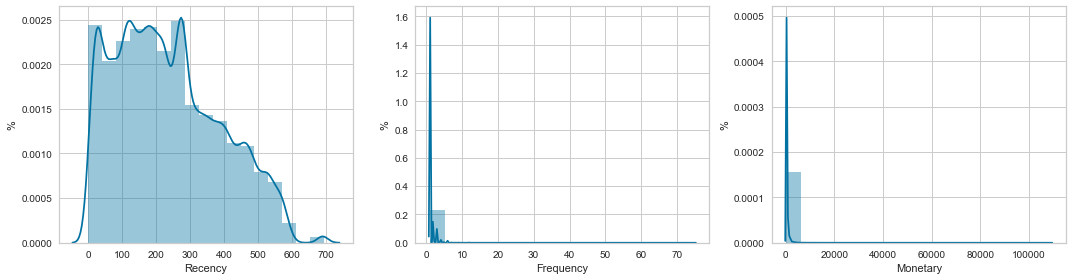

In [9]:
# Application de la fonction histogramme RFM à df
hist_rfm(rfm)

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Fut

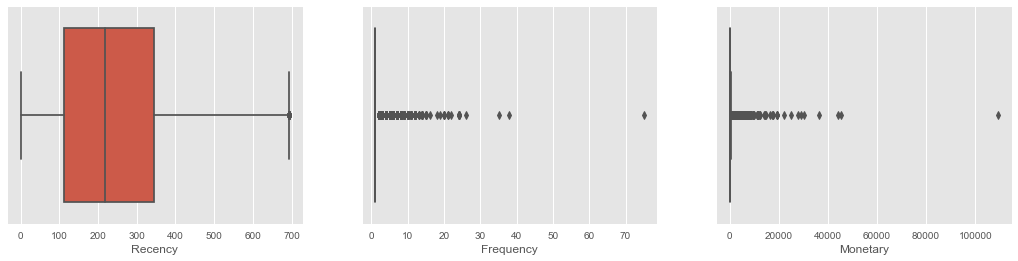

In [10]:
# Application de la fonction boxplot RFM à df
boxplot_rfm(rfm)

In [11]:
quintiles = rfm[['Recency',
                 'Frequency',
                 'Monetary']].quantile([.2, .4, .6, .8])
quintiles

Recency  Frequency  Monetary
0.2     90.0        1.0     56.05
0.4    175.0        1.0     89.88
0.6    267.0        1.0    140.07
0.8    380.0        1.0    238.69

In [12]:
def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    """
    #print(x)
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [13]:
# pour le M on attibu 1 pour la monetory [238,109312]
# 2 pour la monetory [140, 238]
# 3 pour la monetory [89, 140]
# 4 pour la monetory [56, 89]
# 5 si monetory [9 ,56]


# Pour R on attribu 1 pour les valeurs de Rencency comprise entre [381 ,694]
# 2 pour les valeurs de Recency comprise entre [268,380]
# 3 pour [176 , 267]
# 4 pour [91, 175]
# 5 pour [0, 90]

rfm['R'] = pd.qcut(rfm['Recency'], 5, ['5','4','3','2','1']).astype(np.int64)
rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
rfm['M'] = pd.qcut(rfm['Monetary'], 5, ['5','4','3','2','1']).astype(np.int64)



In [48]:
#grouped = rfm.groupby('R')
#for name,group in grouped:
 #  print (name)
  # print (group.max(), group.min())

# Modélisation: 
- Dans cette partie, la segmentation de la base de client est effectuée par l'utilisation d'un modèle de clustering.
- La base de données est aggrégé par clients unique. Cependant les variables catégorielles ne pouvant être aggrégés, il est décidé de les retirer.

In [14]:
data.head(2)

Unnamed: 0                          order_id  \
0           0  e481f51cbdc54678b7cc49136f2d6af7   
1           1  e481f51cbdc54678b7cc49136f2d6af7   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   

    order_approved_at order_delivered_carrier_date  \
0 2017-10-02 11:07:15          2017-10-04 19:55:00   
1 2017-10-02 11:07:15          2017-10-04 19:55:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13                    2017-10-18   
1           2017-10-10 21:25:13                    2017-10-18   

   payment_sequential payment_type  payment_installments  payment_value  \
0                   1  credit_card                     1          18.12   
1                   3      voucher                     1           2.00   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   

  customer_state  order_item_id                        product_id  \
0             SP              1  87285b34884572647811a353c7ac498a   
1             SP              1  87285b34884572647811a353c7ac498a   

                          seller_id shipping_limit_date  price  freight_value  \
0  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15  29.99           8.72   
1  3504c0cb71d7fa48d967e0e4c94d59d9 2017-10-06 11:07:15  29.99           8.72   

                          review_id  review_score review_creation_date  \
0  a54f0611adc9ed256b57ede6b6eb5114             4           2017-10-11   
1  a54f0611adc9ed256b57ede6b6eb5114             4           2017-10-11   

  review_answer_timestamp  seller_zip_code_prefix seller_city seller_state  \
0     2017-10-12 03:43:48                    9350        maua           SP   
1     2017-10-12 03:43:48                    9350        maua           SP   

   product_category_name  product_name_lenght  product_description_lenght  \
0  utilidades_domesticas                 40.0                       268.0   
1  utilidades_domesticas                 40.0                       268.0   

   product_photos_qty  product_weight_g  product_length_cm  product_height_cm  \
0                 4.0             500.0               19.0                8.0   
1                 4.0             500.0               19.0                8.0   

   product_width_cm product_category_name_english   approved_delay  \
0              13.0                    housewares  0 days 00:10:42   
1              13.0                    housewares  0 days 00:10:42   

  delivery_gap_btw_est_act review_answer_time  product_volume  \
0          7 days 02:34:47    1 days 03:43:48          1976.0   
1          7 days 02:34:47    1 days 03:43:48          1976.0   

   approved_minutes  Year    Month  delivery_time  estimated_delivery_time  
0             642.0  2017  October       8.429144                15.536632  
1             642.0  2017  October       8.429144                15.536632

In [15]:
data['Month']= data['Month'].replace( {'January': 1
                  ,'February':2
                  ,'March':3
                  ,'April':4
                  ,'May': 5
                  ,'June':6
                  ,'July' :7
                  , 'August':8
                  ,'September':9
                  ,'October':10
                  , 'November':11
                  , 'December':12
                   })

In [610]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114050 entries, 0 to 114049
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unnamed: 0                     114050 non-null  int64         
 1   order_id                       114050 non-null  object        
 2   customer_id                    114050 non-null  object        
 3   order_status                   114050 non-null  object        
 4   order_purchase_timestamp       114050 non-null  datetime64[ns]
 5   order_approved_at              114050 non-null  datetime64[ns]
 6   order_delivered_carrier_date   114050 non-null  datetime64[ns]
 7   order_delivered_customer_date  114050 non-null  datetime64[ns]
 8   order_estimated_delivery_date  114050 non-null  datetime64[ns]
 9   payment_sequential             114050 non-null  int64         
 10  payment_type                   114050 non-null  object        
 11  

In [16]:
# Features à agréger
features = [ 'review_score',
            'payment_sequential',
            'freight_value',
            'price',
            'payment_value',
            'order_item_id',
            'product_weight_g',
            'product_photos_qty',
            'product_name_lenght',
            'product_volume', 
            'Year', 
            'Month',
            'delivery_time',
            'estimated_delivery_time', 
            'approved_minutes']

In [17]:
# Agrégation par client unique

fonction = lambda x: round(x.mean(), 0) # Fonction permettant d'obtenir une moyenne entière

data_cluster = data.groupby('customer_unique_id').agg({  'review_score': [fonction],
                                                         'payment_sequential': "sum",
                                                         'freight_value': "sum",
                                                         'price': 'sum',
                                                         'payment_value': "sum",
                                                         

                                                         'order_item_id': 'sum',
                                                         'product_weight_g': "mean",
                                                         'product_photos_qty': [fonction],
                                                         'product_name_lenght': [fonction],
                                                         'product_volume': "mean",
    
                                                         'Year': [fonction],
                                                         'Month': [fonction], 
                                                         'delivery_time': 'mean',
                                                         'estimated_delivery_time': "mean",
                                                         'approved_minutes': 'mean',

                                                         
                                                         })

In [18]:
# Features à agréger: 
data_cluster.columns= features
data_cluster=data_cluster.join(rfm[['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M']])

In [19]:
data_cluster.head()

review_score  payment_sequential  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2             5                   1   
0000b849f77a49e4a4ce2b2a4ca5be3f             4                   1   
0000f46a3911fa3c0805444483337064             3                   1   
0000f6ccb0745a6a4b88665a16c9f078             4                   1   
0004aac84e0df4da2b147fca70cf8255             5                   1   

                                  freight_value   price  payment_value  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2          12.00  129.90         141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f           8.29   18.90          27.19   
0000f46a3911fa3c0805444483337064          17.22   69.00          86.22   
0000f6ccb0745a6a4b88665a16c9f078          17.63   25.99          43.62   
0004aac84e0df4da2b147fca70cf8255          16.89  180.00         196.89   

                                  order_item_id  product_weight_g  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2              1            1500.0   
0000b849f77a49e4a4ce2b2a4ca5be3f              1             375.0   
0000f46a3911fa3c0805444483337064              1            1500.0   
0000f6ccb0745a6a4b88665a16c9f078              1             150.0   
0004aac84e0df4da2b147fca70cf8255              1            6050.0   

                                  product_photos_qty  product_name_lenght  \
customer_unique_id                                                          
0000366f3b9a7992bf8c76cfdf3221e2                 1.0                 60.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                 1.0                 56.0   
0000f46a3911fa3c0805444483337064                 3.0                 49.0   
0000f6ccb0745a6a4b88665a16c9f078                 5.0                 43.0   
0004aac84e0df4da2b147fca70cf8255                 3.0                 58.0   

                                  product_volume  Year  Month  delivery_time  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2          7616.0  2018    9.0       6.400914   
0000b849f77a49e4a4ce2b2a4ca5be3f          5148.0  2018    6.0       2.984005   
0000f46a3911fa3c0805444483337064         43750.0  2017    3.0      25.731759   
0000f6ccb0745a6a4b88665a16c9f078          1045.0  2017    3.0      20.023472   
0004aac84e0df4da2b147fca70cf8255           528.0  2017    7.0      13.126435   

                                  estimated_delivery_time  approved_minutes  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2                10.533819             891.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                 7.232130           26057.0   
0000f46a3911fa3c0805444483337064                27.121493               0.0   
0000f6ccb0745a6a4b88665a16c9f078                31.132442            1176.0   
0004aac84e0df4da2b147fca70cf8255                20.161898            1270.0   

                                  Recency  Frequency  Monetary  R  F  M  
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90  4  1  2  
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19  4  1  5  
0000f46a3911fa3c0805444483337064      536          1     86.22  1  1  4  
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62  2  1  5  
0004aac84e0df4da2b147fca70cf8255      287          1    196.89  2  1  2

In [74]:
#data_sorted = data.sort_values(by='order_purchase_timestamp', ascending=True, axis=0)
#data_sorted.head()

In [75]:
#my_columns = ['freight_value','approved_minutes','seller_state', 'order_item_id','price', 'product_category_name_english']
#sub_data= data_sorted[my_columns]
#sub_data

In [76]:
#sub_data.shape

In [77]:
#sub_data["product_category_name_english"].unique()

In [164]:
#sub_data['seller_state'].value_counts()

In [286]:
#sub_data["product_category_name_english"].replace(Categ_produits, inplace=True)

In [285]:
#sub_data["product_category_name_english"].unique()

In [20]:
def N_Category(df):
    
    #Il faut récupérer les colonnes qualitatives
    #columns = df.select_dtypes(include=['object']).columns
    columns=['seller_state']
    for i in columns:
        
        counts = df[i].value_counts()
        idx = counts[counts < 2000].index
        df.loc[df[i].isin(idx), i] = "Others"
        #print(len(idx), var)
        
    return df

#sub_data = N_Category(sub_data)

In [79]:
#sub_data["seller_state"].value_counts()

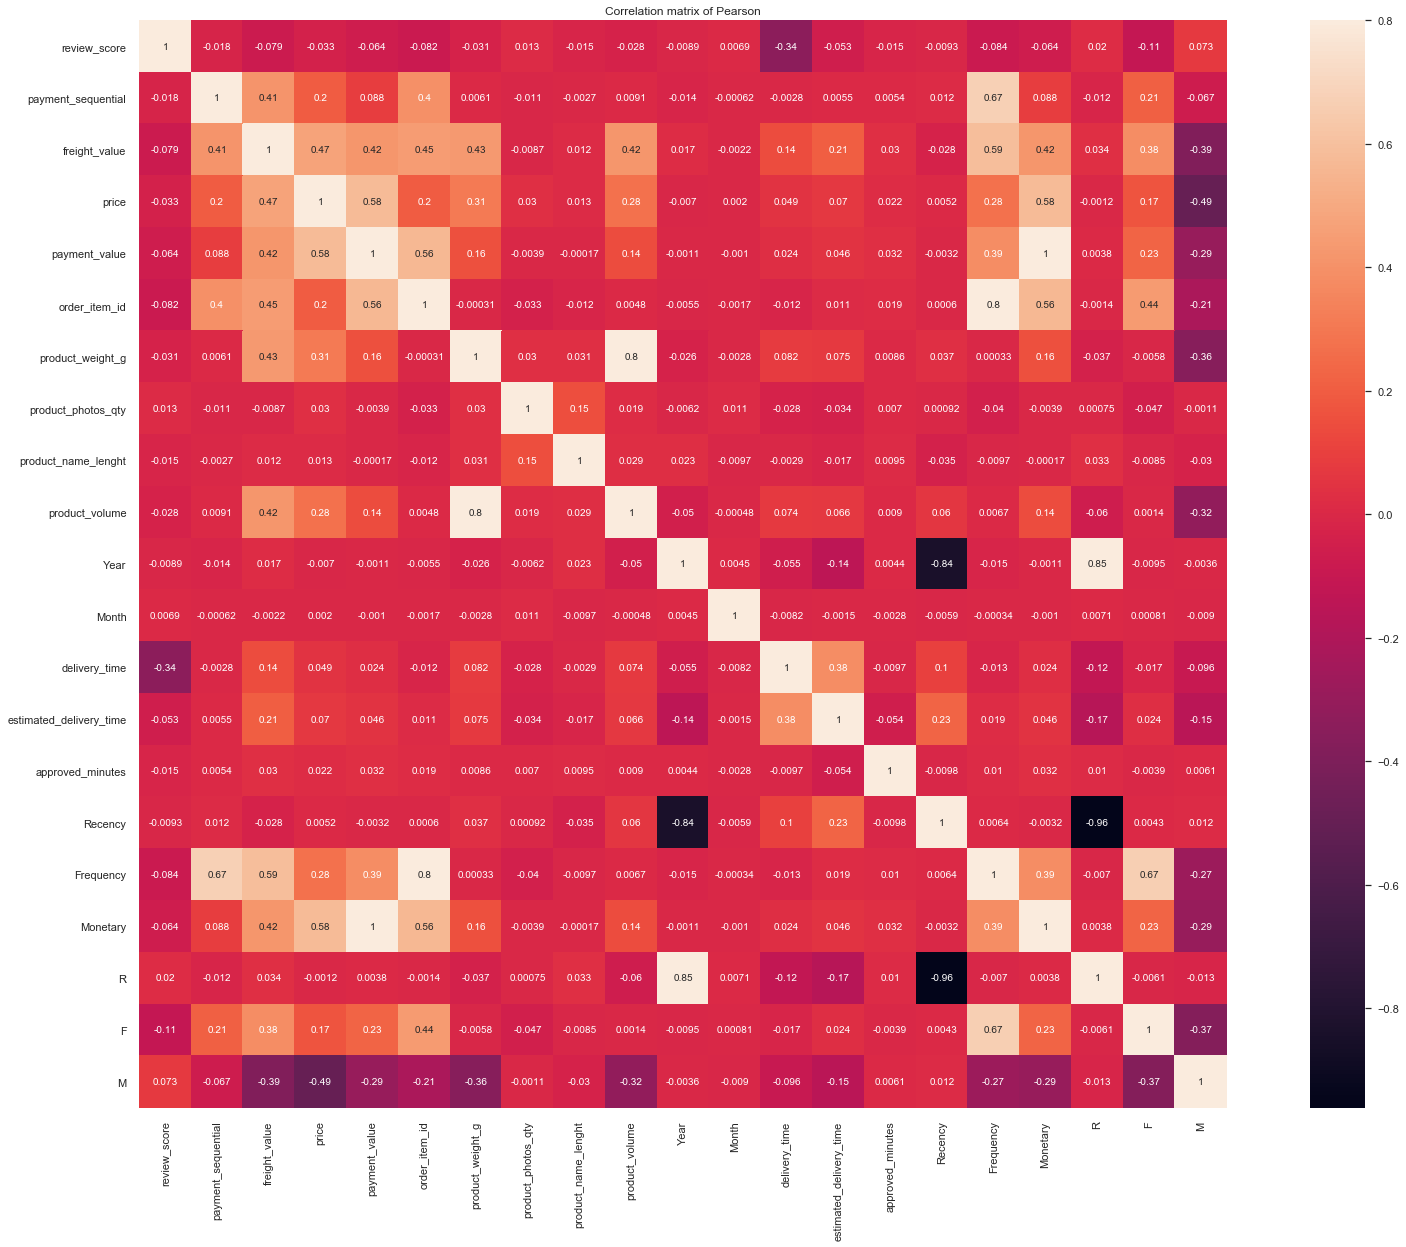

In [472]:
# correlation matrix 
corrmat=data_cluster.corr()
f, ax=plt.subplots(figsize=(30, 20))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.title('Correlation matrix of Pearson')
plt.show()

# 3D Visualization:

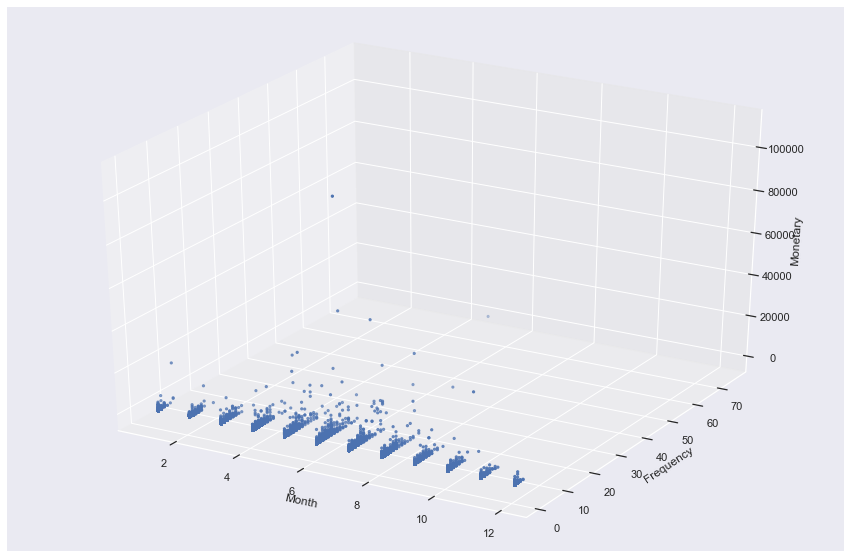

In [473]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =data_cluster.Month
ys = data_cluster.Frequency
zs = data_cluster.Monetary
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

# Pre_processing: 

In [370]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
# OneHot e,coding sur order_status, payment_type, customer_state, 
def OHE_Encoder(col, df):
    OHE_encoder = OneHotEncoder()
    train_ohe = OHE_encoder.fit_transform(df[col])
   
    df=df.drop(columns=col, axis=1)
    df=pd.concat([df,train_ohe], axis=1 ) 
    return df
# target Encoding sur product_category_name_english avec le price 
def Target_encoder(df, col, df_Target):
    TE_encoder = TargetEncoder()
    df_en = TE_encoder.fit_transform(df[col], df_Target)
    
    
    df= df.drop(columns=col, axis=1)
    df=pd.concat([df,df_en], axis=1 )

    return df
# customer_state garder que 4 les plus présente!!!!!!!
#col_Encoder=['seller_state']
#sub_data= OHE_Encoder(col_Encoder, sub_data)

#col_TragetEn=['product_category_name_english']
#sub_data=Target_encoder(sub_data, col_TragetEn, sub_data['price'])

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2056: FutureWarning: 

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 1.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seab

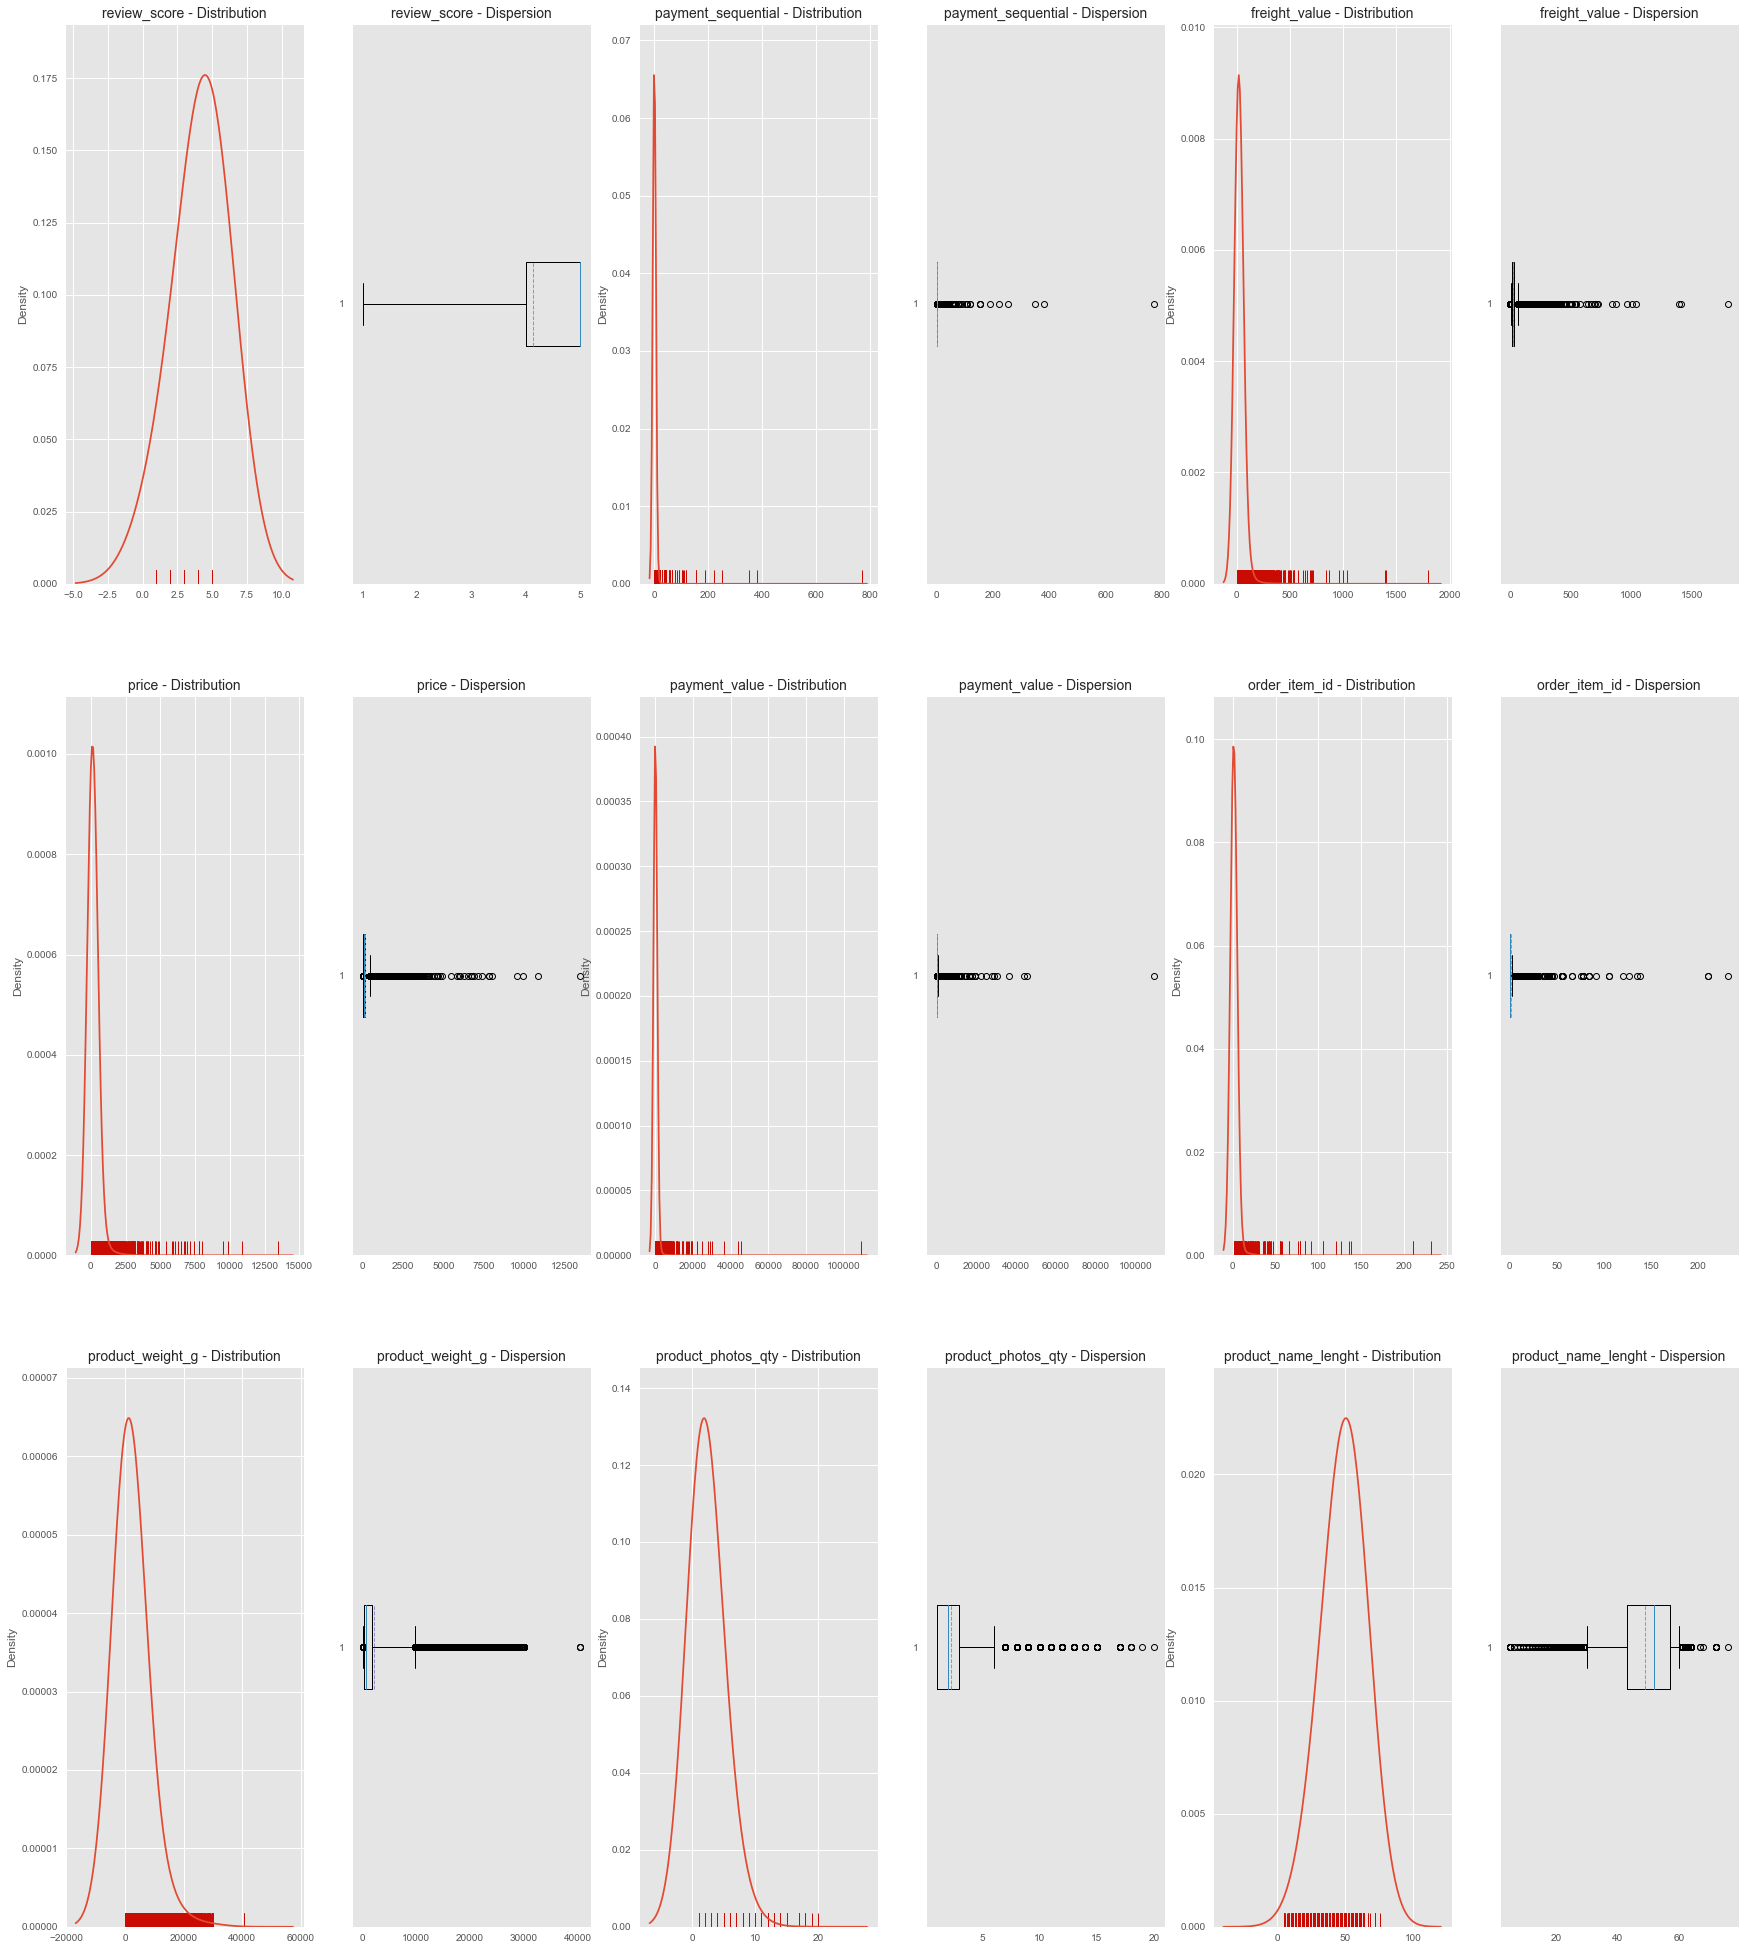

In [21]:
import scipy.stats as stats

nbr_lignes = 3
nbr_colonnes = 6
num_graph = 1

plt.subplots(figsize=(30, 35))

for i in data_cluster:
    if data_cluster[i].dtype !='object' :
        if num_graph <= nbr_lignes * nbr_colonnes:

            mydata = data_cluster[i]
            mydata.dropna(axis=0, inplace=True)

            plt.subplot(nbr_lignes,nbr_colonnes, num_graph)
            #sns.kdeplot(mydata, cumulative=True, bw=1.5)
            sns.distplot(mydata, hist = False, rug = True, rug_kws = {'color' : 'r'}, kde_kws = {'bw' : 1.5, 'kernel' : 'tri'})
            plt.title(i + " - Distribution",size=14)
            plt.xlabel('')

            num_graph +=1
            plt.subplot(nbr_lignes,nbr_colonnes, num_graph)
            plt.boxplot(mydata,whis=[5,95], meanline=True, showmeans=True, vert=False)
            plt.grid()
            plt.title(i + " - Dispersion",size=14)
            num_graph +=1

            #if i == "GHGEmissionsIntensity":
            #    break

plt.show()

# Echantillonage:

In [22]:
# travailler sur les 10 mille premiere en terme chnonologique 
def echantillon(data):
    df_work= data.sample(n=10000)
    return df_work

def split_data(sub_data):
    # splitting dataframe by row index 
    df_1 = sub_data.iloc[:20000,:] 
    df_2 = sub_data.iloc[20000:40000,:] 
    df_3 = sub_data.iloc[40000:60000,:] 
    df_4 = sub_data.iloc[60000:80000,:] 
    df_5 = sub_data.iloc[80000:,:] 
    print("Shape of new dataframes - {} , {},{} , {},{} ".format(df_1.shape, df_2.shape, df_3.shape, df_4.shape, df_5.shape)) 
    return df_1, df_2, df_3, df_4, df_5

# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 22000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size else 0)
    #num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks


# Normalization des données: 

### quantile_transform:

In [23]:
def nomalize(data):
    X_normal= pd.DataFrame(quantile_transform(data, output_distribution="normal", copy=True), columns=data.columns, index = data.index)

    return X_normal

# PCA: 

In [25]:
def PCA_(data):
    #
    pca = PCA(0.99)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents)
    EVR= pca.explained_variance_ratio_*100

    fig, ax = plt.subplots(figsize=(14, 5))
    sns.set(font_scale=1)
    plt.step(range(len(EVR)), EVR.cumsum(), where='mid',
         label='cumulative explained variance')
    sns.barplot(np.arange(len(EVR)),EVR, alpha=0.5, color = 'g',
            label='individual explained variance')
    plt.xlim(0, len(EVR))

    ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

    plt.ylabel('Explained variance', fontsize = 10)
    plt.xlabel('Principal components', fontsize = 10)
    plt.legend(loc='upper left', fontsize = 10);
    return principalDf


# TSNE: 

In [26]:
# varié la perplexity
def TSNE_(data):   
    tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
    X_tsne = tsne.fit_transform(data) # this will either fail or take a while (most likely overnight)

    DF_TSNE= pd.DataFrame(X_tsne, columns=["tsne_1", "tsne_2"])
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=DF_TSNE["tsne_1"], 
                    y=DF_TSNE["tsne_2"],
                    hue=data["labels"],
                     palette=sns.color_palette("hls", n_colors = len(data["labels"].unique())),
                     data=DF_TSNE , legend="full")
    #plt.legend(loc='best', shadow=False, scatterpoints=3)
    plt.title('Scatter plot of t-SNE embedding')
    plt.xlabel('data')
    plt.ylabel('Y')
    plt.savefig('t-SNE-porto-01.png', dpi=150)
    plt.show()

# KMeans:
- Le clustering K-means appartient à la famille d'algorithmes de clustering dur basés sur les partitions \ centroid, une famille d'algorithmes où chaque échantillon d'un ensemble de données est affecté à exactement un cluster.
- Sur la base de cette métrique de distance euclidienne, nous pouvons décrire l'algorithme des k-moyennes comme un simple problème d'optimisation, une approche itérative pour minimiser la somme intra-cluster des erreurs quadratiques (SSE), parfois également appelée inertie de cluster.Ainsi, l'objectif du clustering K-Means est de minimiser la variance intra-cluster totale, ou la fonction d'erreur quadratique:

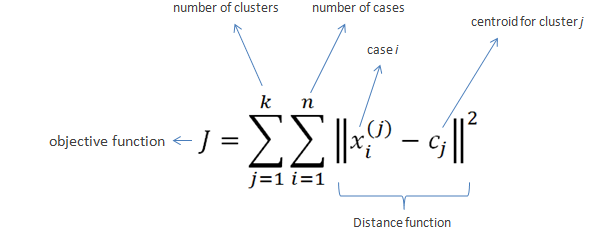


> Les étapes qui se produisent dans l'algorithme K-means pour partitionner les données sont les suivantes:
- L'algorithme commence par des initialisations ponctuelles aléatoires du nombre requis de centres.Le «K» dans K-means représente le nombre de clusters.
- À l'étape suivante, chacun des points de données est affecté au centre le plus proche de lui.La métrique de distance utilisée dans le clustering K-means est la distance euclidienne normale.
- Une fois les points de données attribués, les centres sont recalculés en faisant la moyenne des dimensions des points appartenant au cluster.
- Le processus est répété avec de nouveaux centres jusqu'à ce que nous atteignions un point où les affectations deviennent stables.Dans ce cas, l'algorithme se termine.

> k-means++:
- Placez les centres de gravité initiaux éloignés les uns des autres via l'algorithme k-means ++, ce qui conduit à des résultats meilleurs et plus cohérents que les k-means classiques.
- Pour utiliser k-means ++ avec l'objet KMeans de scikit-learn, nous devons juste définir le paramètre init sur k-means ++ (le paramètre par défaut) au lieu de random.


> Elbow Method: 
- Utilisation de la méthode du coude( elbow) pour trouver le nombre optimal de clusters. L'idée derrière la méthode du coude est d'identifier la valeur de k là où la distorsion commence à augmenter le plus rapidement. Si k augmente, la distorsion diminuera, car les échantillons seront plus proches des centres de gravité auxquels ils sont affectés.



> Silhoutte analysis on K-Means clustering:
- L'analyse de silhouette peut être utilisée pour étudier la distance de séparation entre les clusters résultants, en tant que stratégie pour quantifier la qualité du clustering via un outil graphique pour tracer une mesure du degré de regroupement des échantillons dans les clusters.Le graphique en silhouette affiche une mesure de la proximité de chaque point d'un cluster par rapport aux points des clusters voisins et fournit ainsi un moyen d'évaluer visuellement des paramètres tels que le nombre de clusters.
- Il peut également être appliqué à des algorithmes de clustering autres que k-means
- Les coefficients de silhouette ont une plage de [-1, 1], calculés par:
- Calculez la cohésion du cluster a(i) comme la distance moyenne entre un échantillon x(i) et tous les autres points de même cluster.
- Calculer la séparation des clusters b(i) à partir du prochain cluster le plus proche comme étant la distance moyenne entre l'échantillon x(i) et tous les échantillons des clusters les plus proche.
- Calculez la silhouette s (i) comme la différence entre la cohésion et la séparation de cluster divisée par le plus grand des deux, comme indiqué ici:

 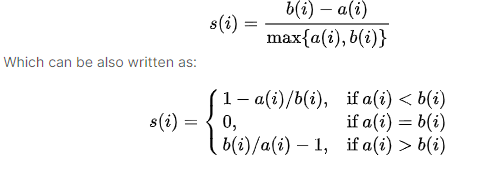
 
 - Le plot de silhouette peut montrer un mauvais choix de clusters K pour les données  en raison de la présence de groupes avec des scores de silhouette inférieurs à la moyenne et également en raison de grandes fluctuations dans la taille des graphiques de silhouette. Un bon k clusters peut être trouvé lorsque toutes les parcelles sont plus ou moins d'épaisseur similaire et sont donc de tailles similaires.

- K-means cherche la position des clusters qui minimise la distance entre les points d'un cluster (xi) et le centre (ui) de ce dernier 

# Les Hyper-parametres:
- n_clusters= nombre k de clusters 
- n_init= nombre d'exécustion (10)
- max_iter = nombre d'itérations (300)
- Init= type d'initialisation (k_means++)

# Méthode: 

- Fit(X)= Exécuter l'alg k-means 
- Predict(X) = centroid le plus proche de X
- Score(X) = Clacul de l'inertia (negatif) 

# Attributs: 
- Cluster_centers_= position des centroids 
- Labels_ = equivalent de Predict(X_train)
- inertia= Clacul de l'inertia( positif) 


# Selecting the number of clusters with silhouette analysis on KMeans clustering:


- L'analyse de silhouette peut être utilisée pour étudier la distance de séparation entre les clusters résultants. Le graphique de silhouette affiche une mesure de la proximité de chaque point d'un cluster par rapport aux points des clusters voisins et fournit ainsi un moyen d'évaluer visuellement des paramètres tels que le nombre de clusters. Cette mesure a une plage de [-1, 1]

In [57]:
import matplotlib.cm as cm
def kmeans_clusters_(X, best_hyperparamètres): 
    cluster_centers = dict()
    # range_n_clusters = [2, 3, 4, 5, 6, 8, 9]
    K_best= int(best_hyperparamètres['nbr_clusters'])

    for n_clusters in range(3,K_best+1,1):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = metrics.silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

        
        cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            cmap = cm.get_cmap("Spectral")
            color = cmap(float(i) / n_clusters)
            #color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        cmap = cm.get_cmap("Spectral")
        colors = cmap(cluster_labels.astype(float) / n_clusters)
        #colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    return cluster_centers 

# KMeans: 

In [28]:
def Kmeans_Cluster(data):
    silhouette = []
    score_cali=[]
    score_dav=[]
    disp = []

    result_clusters_list = []
    result_mx_iter_list=[]
    result_ninit_list = []
    result_random_state_list=[]
    result_type_init_list = []

    dataframe_iter = pd.DataFrame()
    
   
    for kclusters in range(2, 10):
        for max_iter in [50, 100, 300]:
            for init in ['random', 'k-means++']:
                for random_state in [None, 10]:
                    for n_init in [5, 10, 20]:
                        # run kmans clustering 
                        kmeans= KMeans(n_clusters= kclusters,
                                        random_state=random_state,
                                        init= init, 
                                        max_iter= max_iter, 
                                        n_init= n_init).fit(data)
                        predictions = kmeans.fit_predict(data)
                         # save the coeffiants 
                        silh_ = metrics.silhouette_score(data, kmeans.labels_)
                        score_kemans_c = calinski_harabasz_score(data, kmeans.labels_)
                        score_kemans_d = davies_bouldin_score(data, predictions)
                        disp_ = kmeans.inertia_

                        silhouette.append(silh_)
                        score_cali.append(score_kemans_c)
                        score_dav.append(score_kemans_d)
                        disp.append(disp_)
                        result_mx_iter_list.append(max_iter)
                        result_clusters_list.append(kclusters)
                        result_ninit_list.append(n_init)
                        result_type_init_list.append(init)
                        result_random_state_list.append(random_state)

    dataframe_iter["coef_silh"] = silhouette
    dataframe_iter["score_calinski"]= score_cali
    dataframe_iter["score_davies"]= score_dav
    dataframe_iter["Inertia"] = disp
    dataframe_iter["nbr_clusters"] = result_clusters_list
    dataframe_iter["n_init"] = result_ninit_list
    dataframe_iter["type_init"] = result_type_init_list
    dataframe_iter["random_state"] = result_random_state_list
    dataframe_iter["max_iter"] = result_mx_iter_list
    return dataframe_iter

In [29]:
def best_hyperparam(data):
    iters= data.where(data["coef_silh"]==data["coef_silh"].max())
    iters.dropna(how="all", inplace=True)
    print("le meilleurs score est: ",iters)
    if iters.shape[0]>0:
        iters= iters.iloc[0,:]
    print(iters)    
        
    return iters    


def new_best_hyperparam(data, nb_cluster):
    iters= data.where(data["nbr_clusters"]==nb_cluster)
    iters.dropna(how="all", inplace=True)
    print("le meilleurs score est: ",iters)
    if iters.shape[0]>0:
        iters= iters.iloc[0,:]
        
    return iters  

In [30]:
def df_history(cluster_centers):
    history_df= pd.DataFrame()
    history_df['clusters_3']= cluster_centers[3]['labels']
    history_df['clusters_4']= cluster_centers[4]['labels']
    history_df['clusters_5']= cluster_centers[5]['labels']
    history_df['clusters_6']= cluster_centers[6]['labels']
   # history_df['clusters_7']= cluster_centers[7]['labels']
   # history_df['clusters_8']= cluster_centers[8]['labels']
   # history_df['clusters_9']= cluster_centers[9]['labels']
    display(history_df.head())
    
    fig = plt.figure(figsize=(25,10))
    f1 = fig.add_subplot(231)
    market = history_df.clusters_4.value_counts()
    g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('4 Clusters')
    f1 = fig.add_subplot(232)
    market = history_df.clusters_5.value_counts()
    g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('5 Clusters')
    
    
    f1 = fig.add_subplot(233)
    market = history_df.clusters_6.value_counts()
    g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('6 Clusters')
    
    
    #f1 = fig.add_subplot(234)
    #market = history_df.clusters_7.value_counts()
    #g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    #plt.title('7 Clusters')
    #f1 = fig.add_subplot(235)
    #market = history_df.clusters_8.value_counts()
    #g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    #plt.title('8 Clusters')
    #f1 = fig.add_subplot(236)
    #market = history_df.clusters_9.value_counts()
    #g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
    #plt.title('9 Clusters')
    plt.show()
    

In [31]:
def plot_results(dataframe_iter):
    
    coef_silh= dataframe_iter.groupby("nbr_clusters", as_index=False)["coef_silh"].max()
    Inertia= dataframe_iter.groupby("nbr_clusters", as_index=False)["Inertia"].min()
    
    score_cali= dataframe_iter.groupby("nbr_clusters", as_index=False)["score_calinski"].max()
    score_dev= dataframe_iter.groupby("nbr_clusters", as_index=False)["score_davies"].max()
    plt.subplots(figsize=(20,10))

    plt.subplot(2,2,1)

    plt.plot(coef_silh["nbr_clusters"], coef_silh["coef_silh"],color="blue" ,marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("Coefficient de silhouette", size=14)
    plt.grid()

    plt.subplot(2,2,2)

    plt.plot(Inertia["nbr_clusters"], Inertia["Inertia"], color="red",marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("inertia_", size=14)
    plt.grid()
    
    plt.subplot(2,2,3)

    plt.plot(score_cali["nbr_clusters"], score_cali["score_calinski"], color= "gold",marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("calinski_harabasz_score", size=14)
    plt.grid()

    plt.subplot(2,2,4)

    plt.plot(score_dev["nbr_clusters"], score_dev["score_davies"],color="green", marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("davies_bouldin_score", size=14)
    plt.grid()

In [32]:
def KMeans_(data, best_hyperparamètres):
   
    coef_silh= best_hyperparamètres['coef_silh']
    inertia= best_hyperparamètres['Inertia']
    nbr_clusters=int(best_hyperparamètres['nbr_clusters'])
    n_init= int(best_hyperparamètres['n_init'])
    type_init= best_hyperparamètres['type_init']
    random_state= best_hyperparamètres['random_state']
    max_iter= int(best_hyperparamètres['max_iter'])
    # run kmans clustering 
    kmeans= KMeans(n_clusters= nbr_clusters,#random_state= random_state,
                    init= type_init, 
                    max_iter= max_iter, 
                    n_init= n_init).fit(data)
   

     #save metrics 
    silh_ = metrics.silhouette_score(data, kmeans.labels_)
    inertia = kmeans.inertia_
    df_kmeans_lables = pd.DataFrame()
    df_kmeans_lables["labels"] = kmeans.labels_
    df_kmeans_lables["nbr_individus"] = 0
    df_kmeans_lables = df_kmeans_lables.groupby("labels", as_index=False).count()
    
    return [kmeans.labels_, df_kmeans_lables ]



# Preprocessing:

In [33]:

from sklearn.impute import SimpleImputer
def imput_val_quantitatives(df):
    # impute variable quantitatives 
    
    var_quantitatives = df.select_dtypes(include=['int64', 'float64']).columns
    #print(var_quantitatives)
    imr = SimpleImputer(missing_values=np.nan, strategy='median')
    df_imputer = imr.fit_transform(df[var_quantitatives])
    
    imputed_df= pd.DataFrame(data= df_imputer, columns=df[var_quantitatives].columns   )
    
    return imputed_df

In [50]:
# Step 1: Echantillonage
#dataset= echantillon(data)
df_1, df_2, df_3, df_4, df_5= split_data(data_cluster)

# Step 2: Imputer 
imputed_data= imput_val_quantitatives(data_cluster)

# step 2 normalization
data_normal=nomalize(imputed_data)


Shape of new dataframes - (20000, 21) , (20000, 21),(20000, 21) , (20000, 21),(12062, 21) 


# Visualisation des variables normalizer: 

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

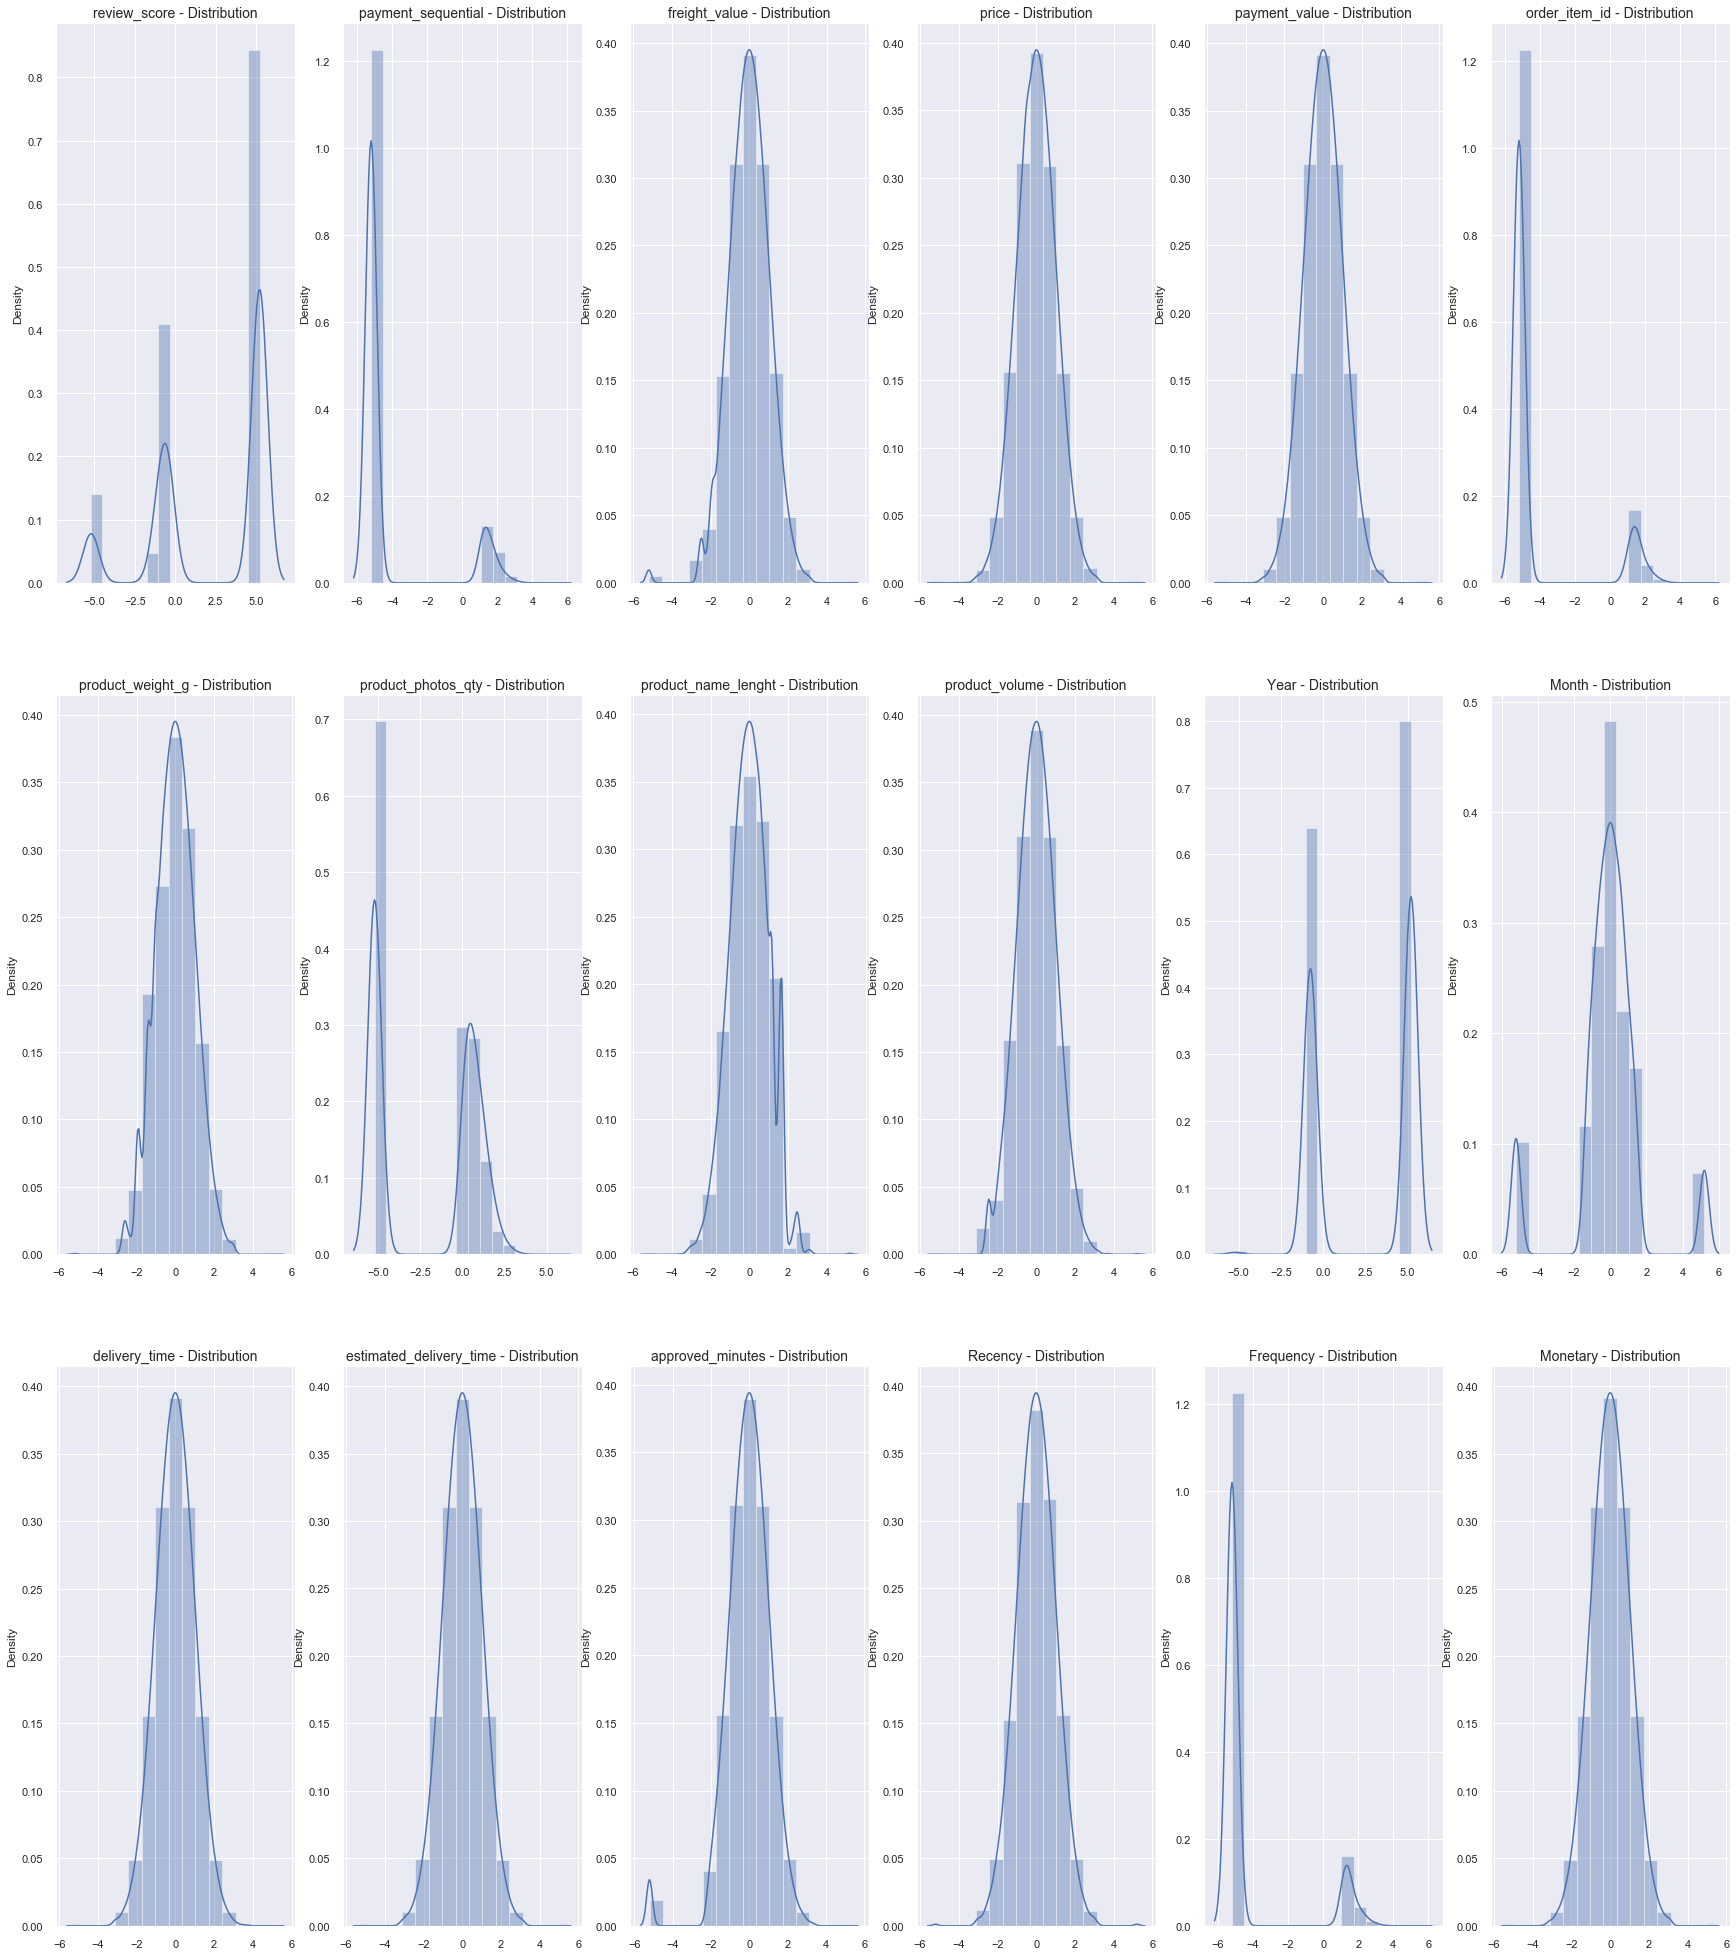

In [44]:
nbr_lignes = 3
nbr_colonnes = 6
num_graph = 1

plt.subplots(figsize=(30, 35))

for i in data_normal:
    if data_normal[i].dtype !='object' :
        if num_graph <= nbr_lignes * nbr_colonnes:

            mydata = data_normal[i]
            mydata.dropna(axis=0, inplace=True)

            plt.subplot(nbr_lignes,nbr_colonnes, num_graph)
            #sns.kdeplot(mydata, cumulative=True, bw=1.5)
            sns.distplot(mydata,bins= int(1+np.log2(len(mydata))))
            plt.title(i + " - Distribution",size=14)
            plt.xlabel('')

            num_graph +=1

plt.show()

# Test de plusieurs méthodes de réduction dimensionnelle: 

In [45]:
from sklearn.decomposition import PCA 
import umap
from sklearn.manifold import TSNE
from sklearn. manifold import Isomap

dict_reducer= { 
                'PCA': PCA(),
                'Isomap': Isomap(n_jobs=-1),
                'TSNE_10': TSNE(perplexity=10), 
                'TSNE_50': TSNE(perplexity=50), 
                'TSNE_90': TSNE(perplexity=100)}

# fonction permettant de tester plusiers reducers sur un meme dataframe
def dimensionality_reduction(data, reducer):
    reducer=reducer
    if reducer == PCA():
        cum_expl_var_ratio= np.cusum(reducer.explained_variance_ratio_)
        num_components= len(cum_expl_var_ratio[cum_expl_var_ratio<= 0.8])
        # return PCA with components that explain 80% of the varaince
        pca= PCA(num_components).fit(data)
        data_pca= pca.transform(data)
        data_pca= pd.DataFrame(data_pca)
        data_reducer = data_pca
        return data_reducer
    else:
        
        data_reducer= reducer.fit_transform(data)
        return data_reducer
    
    
# dictionnaire de dataframes réduits 
dict_data_reduced={ }
for name_reducer, reducer in dict_reducer.items():
    dict_data_reduced[name_reducer]= dimensionality_reduction( data_normal, reducer)

In [46]:
dict_data_reduced

{'PCA': array([[-2.28758725e+00, -2.54637661e+00, -2.40336922e+00, ...,
         -2.95741300e-02, -1.57678704e-02, -1.74511274e-16],
        [-4.28527484e+00, -2.54044650e+00,  2.73054299e+00, ...,
          1.14277572e-01,  1.63614445e-02, -7.65387375e-17],
        [-2.10869357e+00,  6.86734442e+00,  3.39589755e+00, ...,
          3.54782408e-03, -9.54344609e-03, -1.61459726e-17],
        ...,
        [-2.12283358e+00, -1.25570935e+00,  3.90323581e+00, ...,
          1.20027530e-02, -1.33513647e-02,  4.09001170e-18],
        [-2.61522099e+00, -1.72573013e+00, -2.73846907e+00, ...,
         -2.42635105e-02, -1.72257394e-02,  4.35708205e-18],
        [-2.74108063e+00,  2.60712085e+00, -2.77293219e+00, ...,
          1.12343782e-02, -2.33037848e-04,  2.36387775e-19]]),
 'Isomap': array([[  0.1469377 ,   0.12899621],
        [  0.15648623,   0.14524938],
        [-38.00789504, -19.33435606],
        ...,
        [  0.15623017,   0.14477749],
        [  0.15584495,   0.14406989],
        [

# Projection 2D dans les nouveaux plans réduits: 

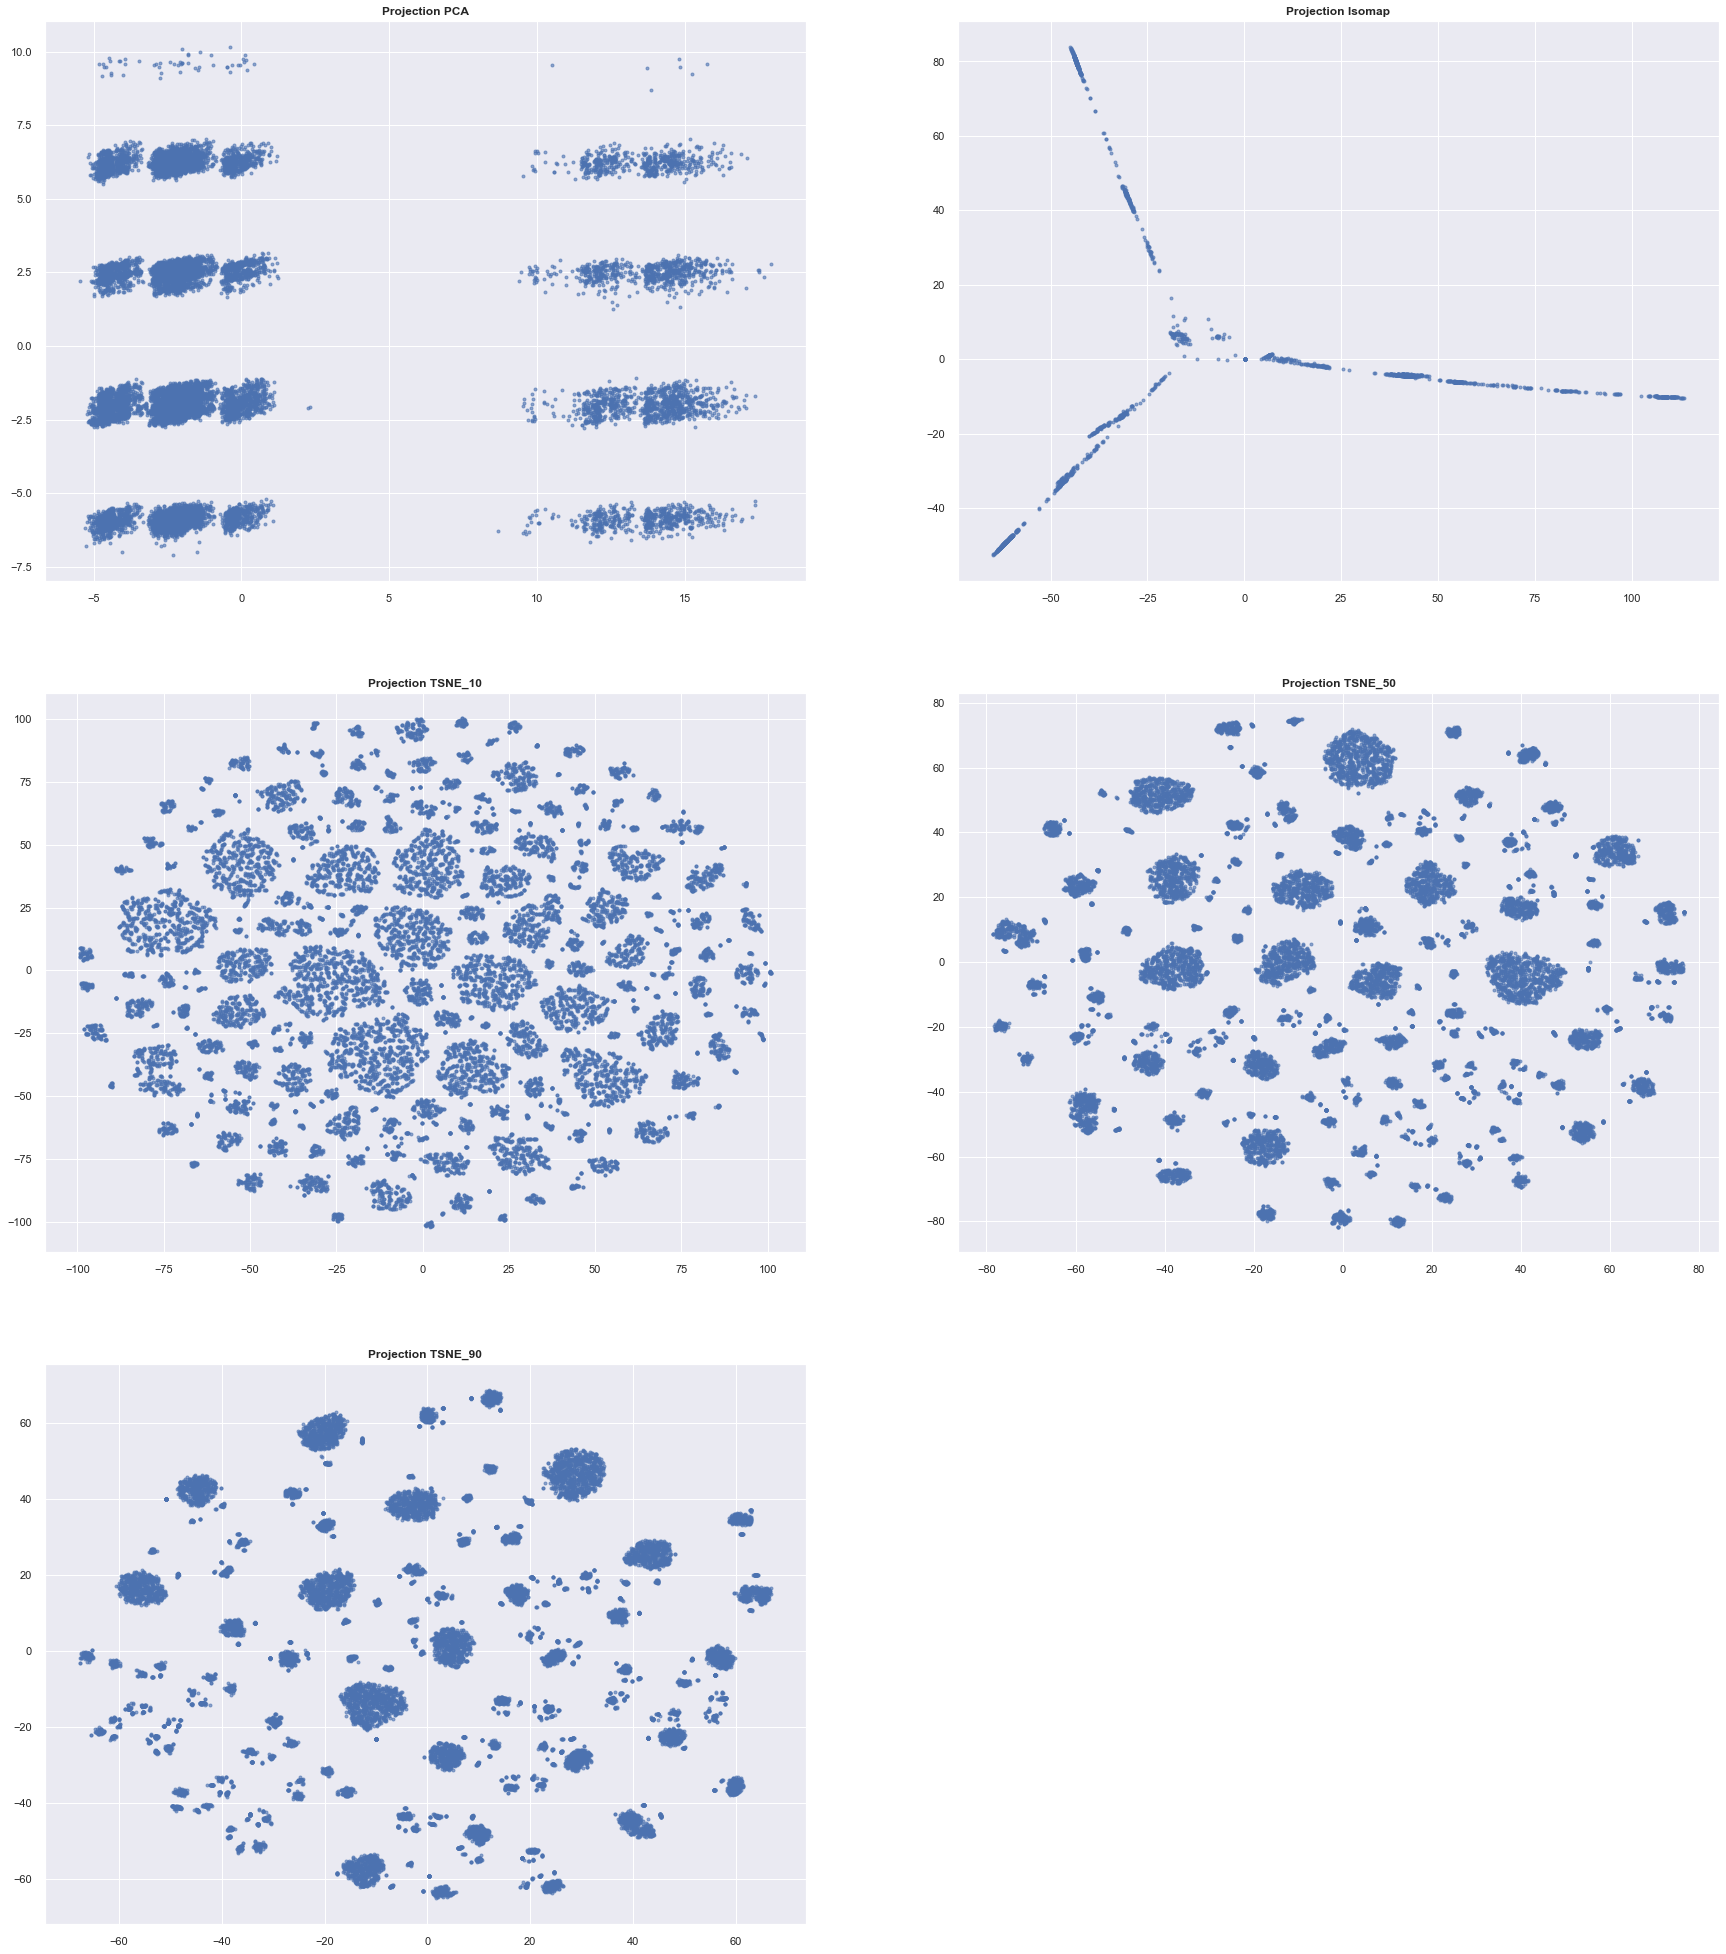

In [47]:
nbr_lignes = 3
nbr_colonnes = 2
num_graph = 1

plt.subplots(figsize=(30, 35))

for name_reducer, data_reduced in dict_data_reduced.items():
    df_reduced = pd.DataFrame(dict_data_reduced[name_reducer])
    if num_graph <= nbr_lignes * nbr_colonnes:

        plt.subplot(nbr_lignes,nbr_colonnes, num_graph)
        plt.scatter(df_reduced.loc[:,0], df_reduced.loc[:,1], alpha=0.6, marker='.')
        plt.title('Projection {}'.format(name_reducer), fontsize=12, weight='bold')

        num_graph +=1

plt.show()


# Modèles de clustering:

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


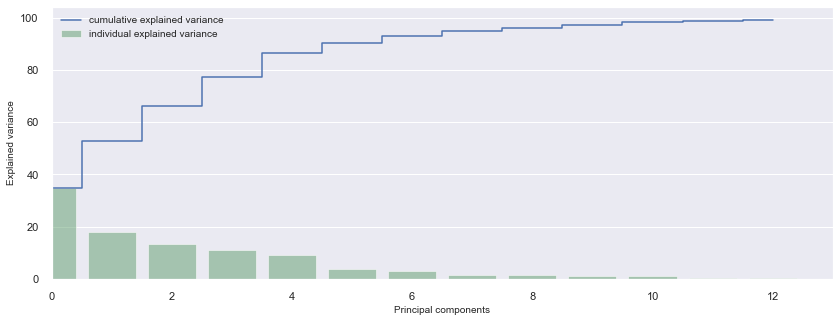

In [48]:
# step 1: plot pca 
data_normal_PCA= PCA_(data_normal)

   coef_silh  score_calinski  score_davies       Inertia  nbr_clusters  \
0   0.438165    10112.272252      0.977464  1.321509e+06             2   
1   0.438165    10112.272252      0.977464  1.321509e+06             2   
2   0.438165    10112.272252      0.977464  1.321509e+06             2   
3   0.438165    10112.272252      0.977464  1.321509e+06             2   
4   0.438165    10112.272252      0.977464  1.321509e+06             2   

   n_init type_init  random_state  max_iter  
0       5    random           NaN        50  
1      10    random           NaN        50  
2      20    random           NaN        50  
3       5    random          10.0        50  
4      10    random          10.0        50  


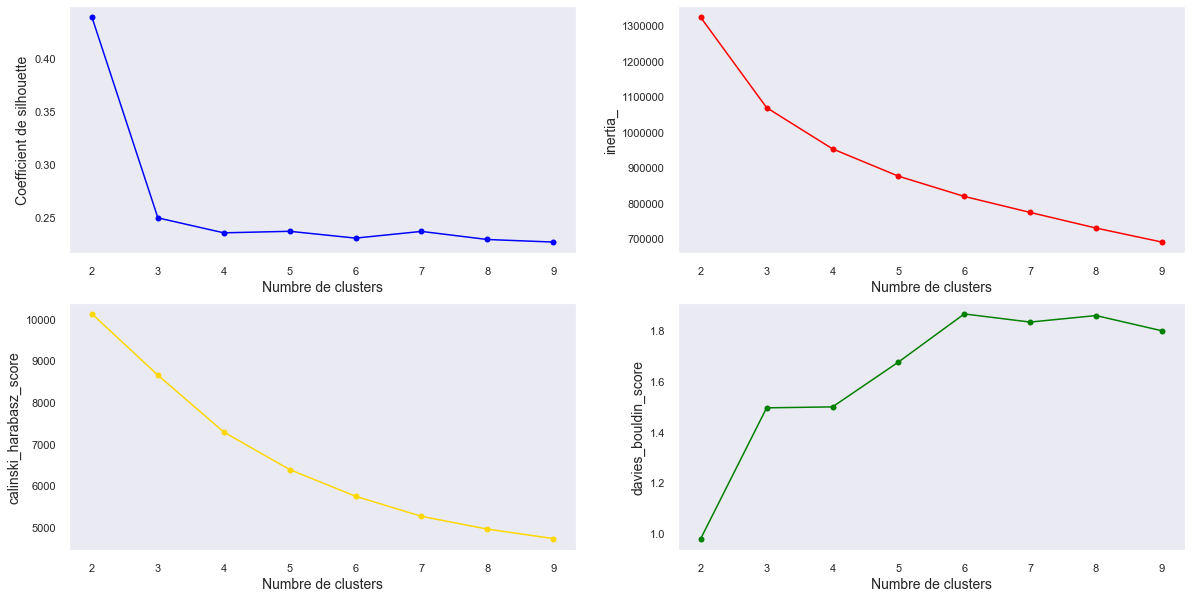

In [49]:
# step 3: grid search on Kmeans
dataframe_iter= Kmeans_Cluster(data_normal)
print(dataframe_iter.head())

# Step 4: affichage des résultats 
plot_results(dataframe_iter)


In [621]:
# step 5: La meilleure itération 
best_hyperparamètres= best_hyperparam(dataframe_iter)
#print("best_hyperparamètres: ",best_hyperparamètres)


le meilleurs score est:      coef_silh  score_calinski  score_davies       Inertia  nbr_clusters  \
0    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
1    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
2    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
3    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
4    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
5    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
6    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
7    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
8    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
9    0.438165    10112.272252      0.977464  1.321509e+06           2.0   
10   0.438165    10112.272252      0.977464  1.321509e+06           2.0   
11   0.438165    10112.272252      0.977464  1.321509e+06           2.0   


In [53]:
# Step 7: update the best hyperapametre 
new_best_hyperparam= new_best_hyperparam(dataframe_iter, 6)
print("best_hyperparamètres: ",new_best_hyperparam)

le meilleurs score est:       coef_silh  score_calinski  score_davies        Inertia  nbr_clusters  \
144   0.230171     5738.294322      1.531756  817144.401085           6.0   
145   0.230177     5738.292679      1.531524  817144.726131           6.0   
146   0.230170     5738.292698      1.531828  817144.728076           6.0   
147   0.219488     5526.486656      1.631635  835314.524474           6.0   
148   0.219488     5526.486656      1.631635  835314.524474           6.0   
149   0.219488     5526.486656      1.631635  835314.524474           6.0   
150   0.217729     5509.653355      1.588734  836793.324432           6.0   
151   0.218307     5667.099248      1.591608  823162.965957           6.0   
152   0.230171     5738.294322      1.531756  817144.264092           6.0   
153   0.227092     5651.766193      1.497779  824470.908323           6.0   
154   0.227092     5651.766193      1.497779  824470.908323           6.0   
155   0.227092     5651.766193      1.497779  82447

For n_clusters = 3 The average silhouette_score is : 0.24884339494496022
For n_clusters = 4 The average silhouette_score is : 0.23538429798301164
For n_clusters = 5 The average silhouette_score is : 0.23676159522546955
For n_clusters = 6 The average silhouette_score is : 0.23088871254523155


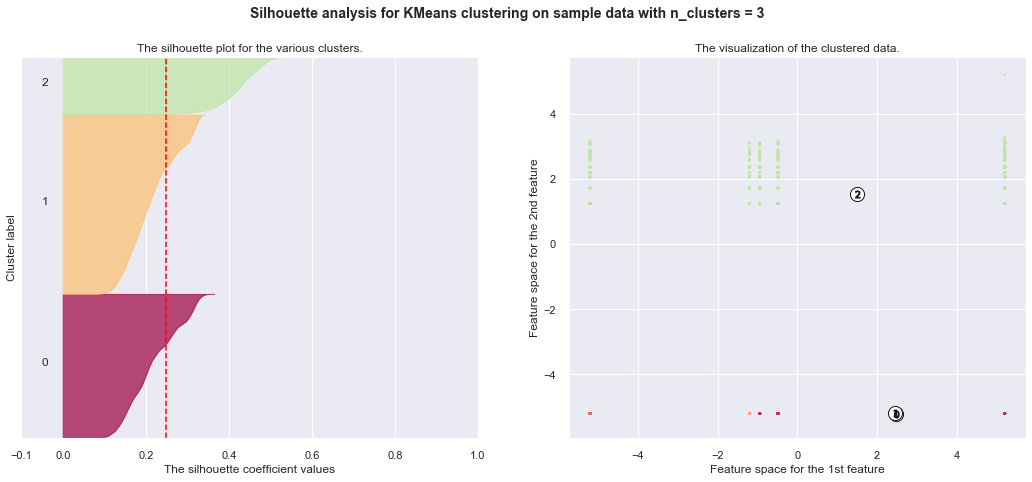

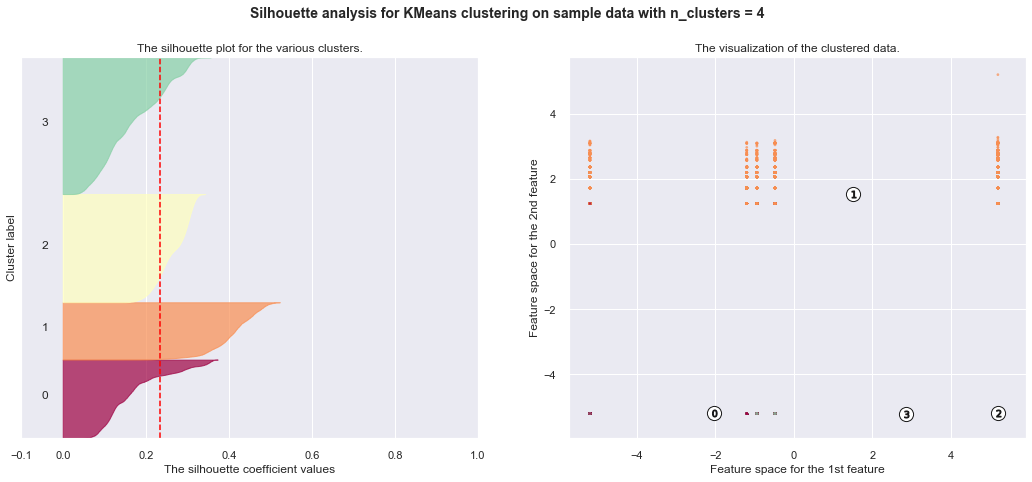

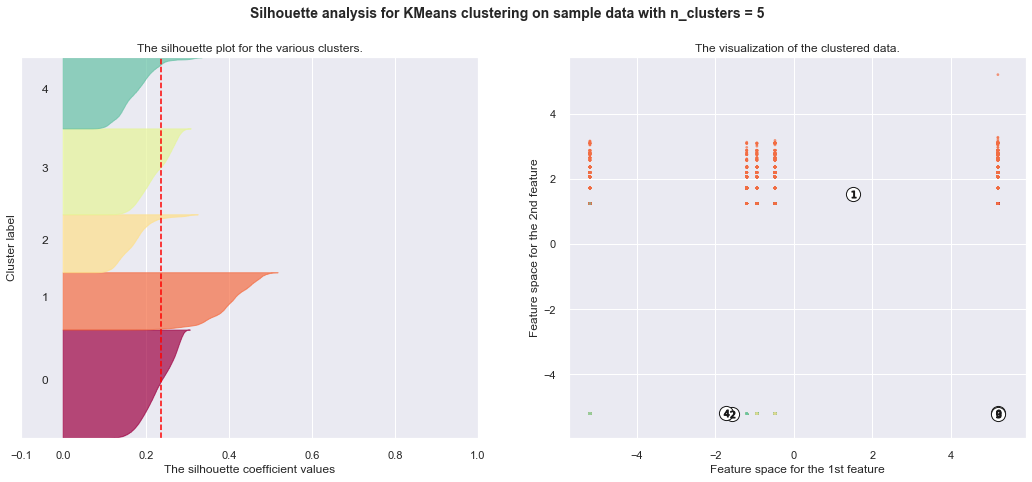

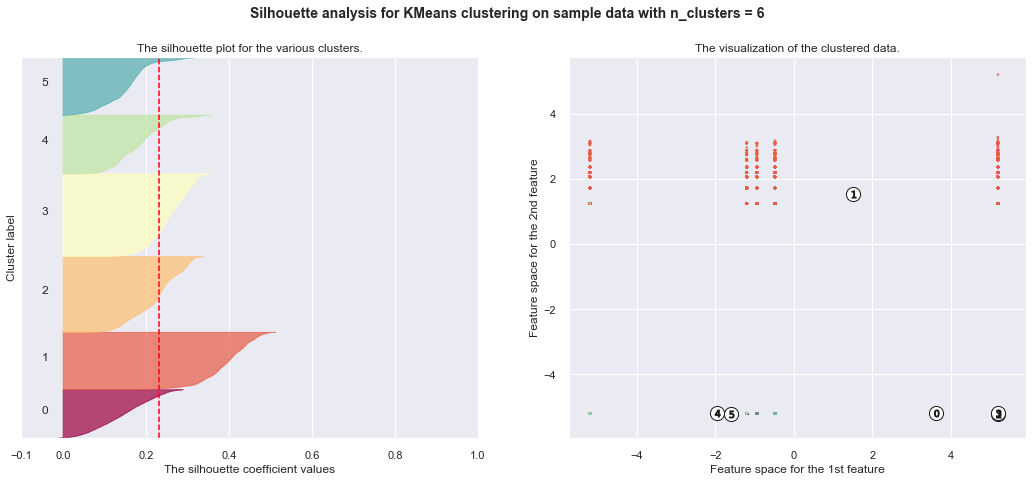

clusters_3  clusters_4  clusters_5  clusters_6
0           1           2           0           3
1           1           0           4           0
2           0           3           2           5
3           0           3           2           5
4           0           3           3           2

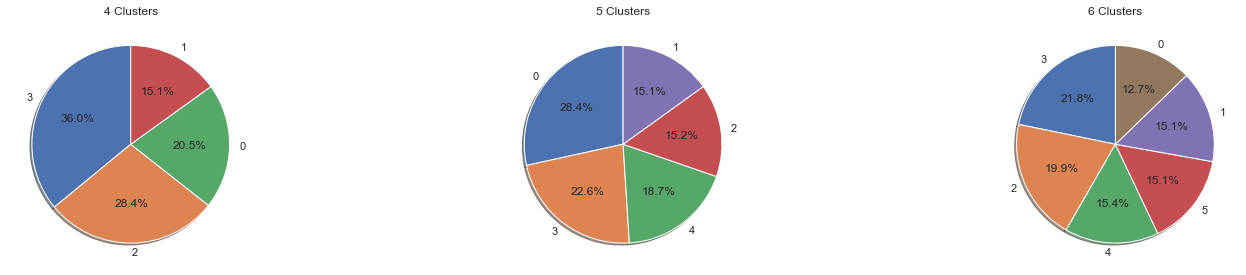

In [58]:
# step 6: silhouette analysis
cluster_centers = kmeans_clusters_(data_normal, new_best_hyperparam)
df_history(cluster_centers)


In [627]:
# step 8: fit le kmeans avec les meilleurs hypr_paramètres  
data_normal['labels']= KMeans_(data_normal, new_best_hyperparam)[0]

In [628]:
data_normal.head()

review_score  payment_sequential  freight_value     price  payment_value  \
0      5.199338           -5.199338      -1.030441  0.425228       0.262160   
1     -0.482248           -5.199338      -1.571286 -1.700222      -2.004433   
2     -0.943656           -5.199338      -0.069895 -0.292676      -0.308606   
3     -0.482248           -5.199338      -0.021329 -1.292465      -1.174387   
4      5.199338           -5.199338      -0.111890  0.817902       0.635707   

   order_item_id  product_weight_g  product_photos_qty  product_name_lenght  \
0      -5.199338          0.497809           -5.199338             1.644369   
1      -5.199338         -0.450080           -5.199338             0.524976   
2      -5.199338          0.497809            0.662724            -0.203379   
3      -5.199338         -1.421556            1.340200            -0.633317   
4      -5.199338          1.247505            0.662724             0.893908   

   product_volume      Year     Month  delivery_time  estimated_delivery_time  \
0        0.067799  5.199338  0.877196      -0.656203                -1.586058   
1       -0.155614  5.199338  0.032625      -1.537380                -2.072844   
2        1.392566 -0.758004 -0.855287       1.479568                 0.570776   
3       -1.453280 -0.758004 -0.855287       1.093543                 0.994341   
4       -2.131682 -0.758004  0.330873       0.444893                -0.378863   

   approved_minutes   Recency  Frequency  Monetary         R         F  \
0         -0.425228 -0.697507  -5.199338  0.262160  0.524976 -5.199338   
1          0.518564 -0.664287  -5.199338 -2.004433  0.524976 -5.199338   
2         -5.199338  1.786156  -5.199338 -0.308606 -5.199338 -5.199338   
3         -0.069674  0.562796  -5.199338 -1.174387 -0.522099 -5.199338   
4         -0.001255  0.421111  -5.199338  0.635707 -0.522099 -5.199338   

          M  labels  
0 -0.522099       0  
1  5.199338       1  
2  0.529301       5  
3  5.199338       5  
4 -0.522099       3

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.366s...
[t-SNE] Computed neighbors for 20000 samples in 11.763s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

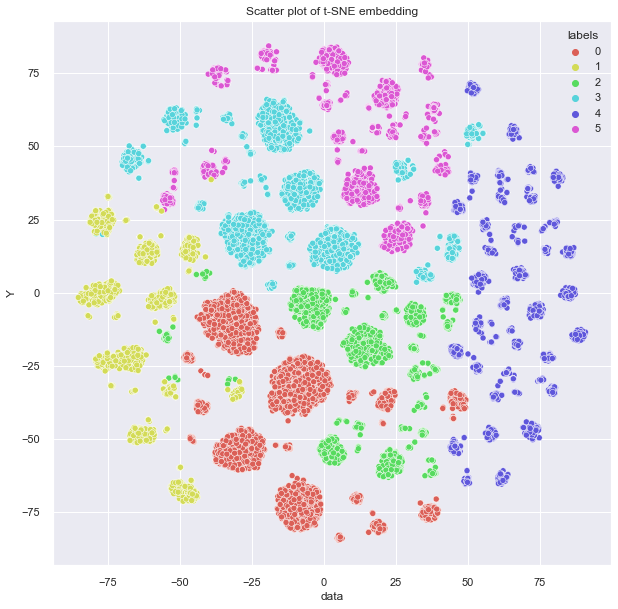

In [629]:
# step 9: plot the TSNE 
TSNE_(data_normal)

# Features importances:

- Un numéro de cluster a été attribué à chaque client unique. Une problématique de classification est maintenant considérée. On cherche à savoir l'importance relative de chaque feature à la prédiction de l'étiquette du cluster issu d'un modèle de classification.



In [630]:
cluster_labels=data_normal['labels']

df_cluster_labels= pd.DataFrame(cluster_labels, index=data_normal.index)
df_cluster_labels.columns= ['cluster_labels']


C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



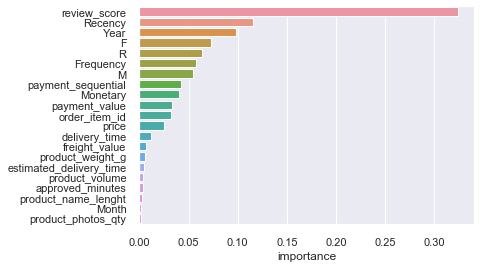

In [631]:
# RandomForest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier

X, y =imputed_data, df_cluster_labels
# define the model
model= RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance 
importance= model.feature_importances_
df_importance= pd.DataFrame(importance, index= X.columns)
df_importance= df_importance.rename(columns={0: 'importance'})
df_importance= df_importance.sort_values(by= ['importance'], ascending= False)

sns.barplot(x='importance', y= df_importance.index, data= df_importance)

- selection des features qui contribuent à au moins 5% dans l'attribution des clusters

In [632]:
features_selected= list(df_importance[df_importance['importance']> 0.05].index)
print(features_selected)

['review_score', 'Recency', 'Year', 'F', 'R', 'Frequency', 'M']


# Caractérisation des clusters

In [633]:
sample_clusterd= imputed_data.join(cluster_labels)
sample_clusterd.head()

review_score  payment_sequential  freight_value   price  payment_value  \
0           5.0                 1.0          12.00  129.90         141.90   
1           4.0                 1.0           8.29   18.90          27.19   
2           3.0                 1.0          17.22   69.00          86.22   
3           4.0                 1.0          17.63   25.99          43.62   
4           5.0                 1.0          16.89  180.00         196.89   

   order_item_id  product_weight_g  product_photos_qty  product_name_lenght  \
0            1.0            1500.0                 1.0                 60.0   
1            1.0             375.0                 1.0                 56.0   
2            1.0            1500.0                 3.0                 49.0   
3            1.0             150.0                 5.0                 43.0   
4            1.0            6050.0                 3.0                 58.0   

   product_volume    Year  Month  delivery_time  estimated_delivery_time  \
0          7616.0  2018.0    9.0       6.400914                10.533819   
1          5148.0  2018.0    6.0       2.984005                 7.232130   
2         43750.0  2017.0    3.0      25.731759                27.121493   
3          1045.0  2017.0    3.0      20.023472                31.132442   
4           528.0  2017.0    7.0      13.126435                20.161898   

   approved_minutes  Recency  Frequency  Monetary    R    F    M  labels  
0             891.0    111.0        1.0    141.90  4.0  1.0  2.0       0  
1           26057.0    114.0        1.0     27.19  4.0  1.0  5.0       1  
2               0.0    536.0        1.0     86.22  1.0  1.0  4.0       5  
3            1176.0    320.0        1.0     43.62  2.0  1.0  5.0       5  
4            1270.0    287.0        1.0    196.89  2.0  1.0  2.0       3

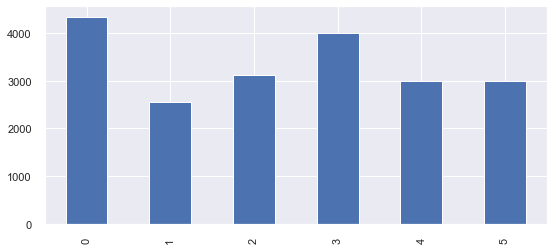

In [634]:
# Répartition des clients dans les clusters
sample_clusterd['labels'].value_counts().sort_index().plot.bar(figsize=(9, 4))

In [635]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = sample_clusterd['labels'],
                   colorscale = [[0,'red'],[0.1,'blue'],[0.2,'yellow'], [0.3,'green'],[0.4,'darkgreen'],
                                 [0.5,'orange'], [0.6,'purple'],[0.7,'lightblue'],[1,'gold']]),
        
        dimensions = list([
            
            
            
            dict(range = [-1,6],
                 tickvals = [0,1,2,3,4,5],
                 label = 'labels', values = sample_clusterd['labels']),
            
            dict(range = [sample_clusterd['Year'].min(),sample_clusterd['Year'].max()],
                 #constraintrange = [100000,150000],
                 label = "Year", values = sample_clusterd['Year']),
            
            dict(range = [sample_clusterd['review_score'].min(),sample_clusterd['review_score'].max()],
                 #constraintrange = [100000,150000],
                 label = "review_score", values = sample_clusterd['review_score']),
            
            dict(range = [sample_clusterd['product_photos_qty'].min(),sample_clusterd['product_photos_qty'].max()],
                 #constraintrange = [100000,150000],
                 label = "product_photos_qty", values = sample_clusterd['product_photos_qty']),
            
            
            dict(range = [sample_clusterd['Recency'].min(),sample_clusterd['Recency'].max()],
                 #constraintrange = [100000,150000],
                 label = "Recency", values = sample_clusterd['Recency']),
        
            dict(range = [sample_clusterd['Frequency'].min(),sample_clusterd['Frequency'].max()],
                 #constraintrange = [100000,150000],
                 label = "Frequency", values = sample_clusterd['Frequency']), 
            dict(range = [sample_clusterd['R'].min(),sample_clusterd['R'].max()],
                 #constraintrange = [100000,150000],
                 label = "R", values = sample_clusterd['R'])
        
        
        
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [636]:
#  from cuml.manifold import TSNE, UMAP

# valeurs moyennes par variables et par clusters
column_names= list(sample_clusterd.columns)
df_mean= pd.DataFrame(columns= column_names)
for i in range(6):
    df_mean= df_mean.append((pd.DataFrame(sample_clusterd[sample_clusterd["labels"]==i].mean())).transpose())
    
    

In [638]:

# Parallel Coordinates Plots pour la caractérisation des clusters

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df_mean['labels'],
                   colorscale = [[0,'red'],[0.1,'blue'],[0.2,'yellow'], [0.3,'green'],[0.4,'darkgreen'],
                                 [0.5,'orange'], [0.6,'purple'],[0.7,'lightblue'],[1,'gold']]),
        
        dimensions = list([
            
            
            
            dict(range = [-1,6],
                 tickvals = [0,1,2,3,4,5],
                 label = 'labels', values = df_mean['labels']),
            
            dict(range = [df_mean['Year'].min(),df_mean['Year'].max()],
                 #constraintrange = [100000,150000],
                 label = "Year", values = df_mean['Year']),
            
            dict(range = [df_mean['review_score'].min(),df_mean['review_score'].max()],
                 #constraintrange = [100000,150000],
                 label = "review_score", values = df_mean['review_score']),
            
            dict(range = [df_mean['product_photos_qty'].min(),df_mean['product_photos_qty'].max()],
                 #constraintrange = [100000,150000],
                 label = "product_photos_qty", values = df_mean['product_photos_qty']),
            
            
            dict(range = [df_mean['Recency'].min(),df_mean['Recency'].max()],
                 #constraintrange = [100000,150000],
                 label = "Recency", values = df_mean['Recency']),
        
            dict(range = [df_mean['Frequency'].min(),df_mean['Frequency'].max()],
                 #constraintrange = [100000,150000],
                 label = "Frequency", values = df_mean['Frequency']), 
            dict(range = [df_mean['R'].min(),df_mean['R'].max()],
                 #constraintrange = [100000,150000],
                 label = "R", values = df_mean['R'])
        
        
        
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

# STabilité temporelle:

- Evaluation de la stabilité temporelle de l'attribution des labels de clusters dans le temps pour chaque mois de la base de données clients.

In [592]:
data_cluster.shape

(90103, 21)

In [593]:
# Step 2: Imputer 
imputed_data= imput_val_quantitatives(data_cluster)
imputed_data.head()

review_score  payment_sequential  freight_value   price  payment_value  \
0           5.0                 1.0          12.00  129.90         141.90   
1           4.0                 1.0           8.29   18.90          27.19   
2           3.0                 1.0          17.22   69.00          86.22   
3           4.0                 1.0          17.63   25.99          43.62   
4           5.0                 1.0          16.89  180.00         196.89   

   order_item_id  product_weight_g  product_photos_qty  product_name_lenght  \
0            1.0            1500.0                 1.0                 60.0   
1            1.0             375.0                 1.0                 56.0   
2            1.0            1500.0                 3.0                 49.0   
3            1.0             150.0                 5.0                 43.0   
4            1.0            6050.0                 3.0                 58.0   

   product_volume    Year  Month  delivery_time  estimated_delivery_time  \
0          7616.0  2018.0    9.0       6.400914                10.533819   
1          5148.0  2018.0    6.0       2.984005                 7.232130   
2         43750.0  2017.0    3.0      25.731759                27.121493   
3          1045.0  2017.0    3.0      20.023472                31.132442   
4           528.0  2017.0    7.0      13.126435                20.161898   

   approved_minutes  Recency  Frequency  Monetary    R    F    M  
0             891.0    111.0        1.0    141.90  4.0  1.0  2.0  
1           26057.0    114.0        1.0     27.19  4.0  1.0  5.0  
2               0.0    536.0        1.0     86.22  1.0  1.0  4.0  
3            1176.0    320.0        1.0     43.62  2.0  1.0  5.0  
4            1270.0    287.0        1.0    196.89  2.0  1.0  2.0

C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



0              1
0     -36106.476220   -7459.482916
1     -10948.620689  -10129.829465
2     -36888.406815   28374.819607
3     -35841.986181  -14151.311749
4     -35746.829355  -13902.546655
...             ...            ...
90098 -35365.648404  238216.570417
90099 -36419.558094   16825.063196
90100 -36202.891187  -11840.384878
90101 -34541.427868  -10710.235875
90102  31173.243338  -13199.859411

[90103 rows x 2 columns]

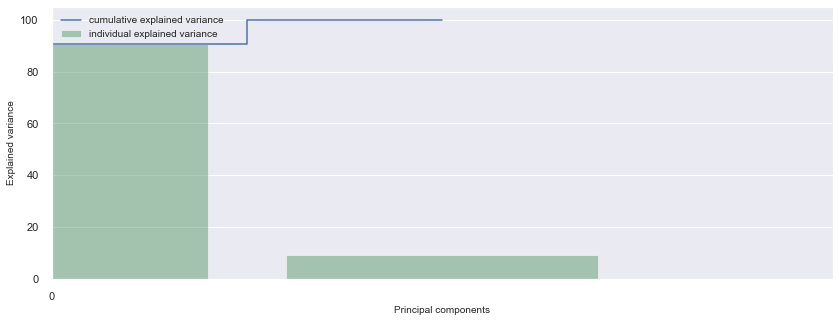

In [594]:
# Réduction de dimension avec la PCA
data_normal_PCA= PCA_(imputed_data)
data_normal_PCA


In [595]:
# Transformation en dataframe
data_cluster.dropna(inplace=True)
data_normal_PCA.columns=['Factor1', 'Factor2']
data_normal_PCA.index= data_cluster.index
data_reduced_time= pd.merge(data_cluster[['Year', 'Month']],data_normal_PCA, left_index=True, right_index=True, how='outer' )


In [429]:
def model_selected(data, best_hyperparamètres):
    coef_silh= best_hyperparamètres['coef_silh']
    inertia= best_hyperparamètres['Inertia']
    nbr_clusters=int(best_hyperparamètres['nbr_clusters'])
    n_init= int(best_hyperparamètres['n_init'])
    type_init= best_hyperparamètres['type_init']
    random_state= best_hyperparamètres['random_state']
    max_iter= int(best_hyperparamètres['max_iter'])
    # run kmans clustering 
    kmeans= KMeans(n_clusters= nbr_clusters,#random_state= random_state,
                init= type_init, 
                max_iter= max_iter, 
                n_init= n_init)
    cluster_labels= kmeans.fit_predict(data)
    df_cluster_labels= pd.DataFrame(cluster_labels, index=data.index)
    df_cluster_labels.rename(columns={0: "clusters"}, inplace=True)
    return df_cluster_labels
    
df_cluster_labels = model_selected(data_reduced_time, new_best_hyperparam)

In [596]:
df_cluster_labels

cluster_labels
0                   2
1                   1
2                   5
3                   5
4                   3
...               ...
19995               2
19996               1
19997               1
19998               4
19999               3

[20000 rows x 1 columns]

# Adjusted_rand_score:


- with fit_predict we get only labels not cluster_centers

In [451]:
from sklearn.metrics.cluster import adjusted_rand_score
nbr_clusters=int(best_hyperparamètres['nbr_clusters'])
year = (data_reduced_time.Year.astype(int).unique()).tolist()
month= (data_reduced_time.Month.astype(int).unique()).tolist()

datasets=[]
Metric_score=[]
for y in year:
    for m in month:
        data= data_reduced_time.loc[(data_reduced_time.Year==y)&
                                   (data_reduced_time.Month==m),:]
        datasets.append(data)

df_merge=[]
for i in range(len(datasets)):
    df_merge.append(datasets[i])
    if len(df_merge)==1:
        df_final= df_merge[0]
        if len(df_final) >= nbr_clusters: 
            df_final.drop(['Year', 'Month'], axis=1, inplace= True)
            clusterer_labels= KMeans_(df_final, new_best_hyperparam)[0]
            labels_true= df_cluster_labels.loc[df_final.index, 'clusters'].tolist()
            Metric_score.append(adjusted_rand_score(labels_true, clusterer_labels))
            
    else: 
        df_final= pd.concat(df_merge)
        if len(df_final) >= nbr_clusters:
            df_final.drop(['Year', 'Month'], axis=1, inplace= True)
            clusterer_labels= KMeans_(df_final, new_best_hyperparam)[0]
            labels_true= df_cluster_labels.loc[df_final.index, 'clusters'].tolist()
            Metric_score.append(adjusted_rand_score(labels_true, clusterer_labels))
            
Metric_score.reverse()        
print(Metric_score)

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[0.9059549350674868, 0.7011583377169156, 0.9059361147586589, 0.9061750457119697, 0.906178947855181, 0.9061901257366353, 0.9061932800209852, 0.7011469761618533, 0.9066709765071914, 0.701404649832069, 0.9069919511933208, 0.7012126707795312, 0.9078161942207381, 0.9062469469170997, 0.9086332089560775, 0.9083836424887448, 0.9083582831664179, 0.9079534086466526, 0.9039687818122237, 0.7068988625434361, 0.9024041928909817, 0.9020712906204142, 0.8989736855890629, 0.8957828364432766, 0.895283243476174, 0.8970487932739091, 0.8963818013419584, 0.892926115010581, 0.7230225805492433, 0.89348154710395, 0.8939229881690097, 0.8960268307430002, 0.7357313978093862, 0.9237012715411066, 0.8926148538258671, 0.6842000680136779]


Text(0, 0.5, 'Stabilité - coefficient ARI')

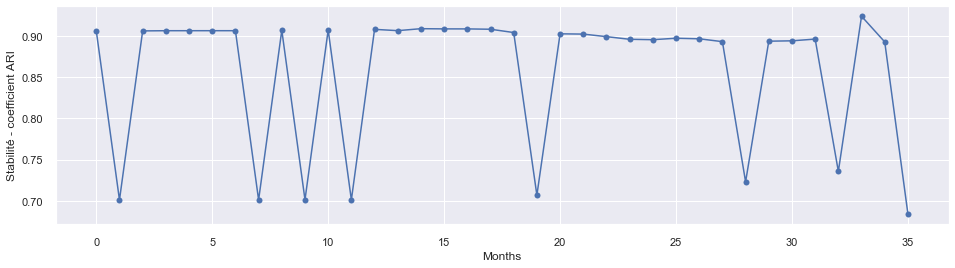

In [452]:
#Plot des résultats
fig = plt.figure(figsize=(16, 4))
plt.plot(range(len(Metric_score)), Metric_score, marker='o')
plt.xlabel('Months')
plt.ylabel('Stabilité - coefficient ARI')

 # A short explanation for every score:
    # homogeneity:          each cluster contains only members of a single class (range 0 - 1)
    # completeness:         all members of a given class are assigned to the same cluster (range 0 - 1)
    # v_measure:            harmonic mean of homogeneity and completeness
    # adjusted_rand:        similarity of the actual values and their predictions,
    #                       ignoring permutations and with chance normalization
    #                       (range -1 to 1, -1 being bad, 1 being perfect and 0 being random)
    # adjusted_mutual_info: agreement of the actual values and predictions, ignoring permutations
    #                       (range 0 - 1, with 0 being random agreement and 1 being perfect agreement)
    # silhouette:           uses the mean distance between a sample and all other points in the same class,
    #                       as well as the mean distance between a sample and all other points in the nearest cluster
    #                       to calculate a score (range: -1 to 1, with the former being incorrect,
    #                       and the latter standing for highly dense clustering.
    #                       0 indicates overlapping clusters.
    # calinski_harabasz_score: It is also known as the Variance Ratio Criterion.
    # The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.
    
    
    #  davies_bouldin_score: The score is defined as the average similarity measure of each cluster with its most similar       #  cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters         #  which are farther apart and less dispersed will result in a better score.
    # The minimum score is zero, with lower values indicating better clustering
    #


- RFM:  Récence, Fréquence et Valeur Monétaire, de la valeur client pour trouver nos segments de clientèle.
- Le modèle RFM prendra les transactions d'un client et calculera trois attributs informationnels importants sur chaque client:

- Récence: La valeur de la date à laquelle un client a acheté récemment dans l'établissement
- Fréquence: La fréquence des transactions du client dans l’établissement.
- La valeur en dollars (ou en livres dans notre cas) de toutes les transactions que le client a effectuées à l'établissement
> Récence: Pour créer la variable de fonctionnalité de récence, nous devons décider de la date de référence de notre analyse. Habituellement, nous utilisons la date de la dernière transaction plus un jour. Ensuite, nous construirons la variable de récence comme le nombre de jours avant la date de référence lorsqu'un client a effectué un dernier achat.

# Density Based Spacial Clustering of Applications with noise (DBSCAN):


- L'idée centrale de DBSCAN est autour du concept de régions denses. L'hypothèse est que les clusters naturelles sont composées de points densément localisés. Cela nécessite la définition de «région dense». Pour faire ces deux paramètres sont nécessaires pour l'algorithme DBSCAN.
- - Eps, -distance 
- - MinPts- Nombre minimum de points à distance Eps

> «Région dense» est donc créée par un nombre minimum de points à distance entre tous, Eps. Les points qui se trouvent dans cette distance mais pas près du nombre minimum d'autres points sont traités comme des «points frontières». Les autres sont le bruit ou les valeurs aberrantes. Ceci est montré dans l'image ci-dessous (pour MinPts = 3). Les points rouges (D) sont dans une «région dense» - chacun a au moins 3 voisins à distance Eps. Les points verts (B) sont des points frontières - ils ont un voisin à distance Eps mais inférieur à 3. Le point bleu (O) est une valeur aberrante - aucun voisin à distance Eps.
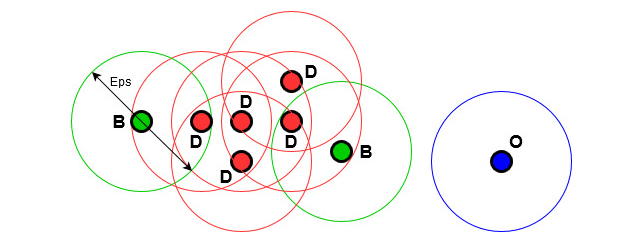


#### les avantages de DBSCAN: 
- Trouve elle meme le nombre de clusters, basé sur les paramètres Eps et MinPts
- Elle est capable de différencier les clusters allongées ou les clusters entourées par d'autres clusters contrairement à K-Means ou les clusters sont toujours convexes  
- Elle est également capable de trouver des points qui ne correspondant à aucun cluster- elle détecte les valeurs abérantes 

#### Le plus gros inconvénient de DBSCAN:
- Temps d'éxécution élevées à O(n log (n)) provenant du besoin d'exécuter une requête de voisinage pour chaque point.
- Identifie mal les clusters de différentes densités

In [500]:
#help(DBSCAN)
from itertools import product

In [501]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
def Epsilon(cluster_df):
    nearest_neighbors = NearestNeighbors(n_neighbors=11)
    neighbors = nearest_neighbors.fit(cluster_df)
    distances, indices = neighbors.kneighbors(cluster_df)
    distances = np.sort(distances[:,10], axis=0)
    print(distances)
    
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    fig = plt.figure(figsize=(10, 10))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print(distances[knee.knee])
    return distances[knee.knee]

In [504]:
def plot_results_dbscan(dataframe_iter):
    
    coef_silh= dataframe_iter.groupby("nbr_clusters", as_index=False)["coef_silh"].max()
    score_cali= dataframe_iter.groupby("nbr_clusters", as_index=False)["score_calinski"].min()
    score_dev= dataframe_iter.groupby("nbr_clusters", as_index=False)["score_davies"].max()
    #Eps= dataframe_iter.groupby("nbr_clusters", as_index=False)["epsilon"]

   
    plt.subplots(figsize=(20,10))

    plt.subplot(2,2,1)

    plt.plot(coef_silh["nbr_clusters"], coef_silh["coef_silh"], color="red",marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("Coefficient de silhouette", size=14)
    plt.grid()

    
    plt.subplot(2,2,2)

    plt.plot(score_cali["nbr_clusters"], score_cali["score_calinski"],color="green" ,marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("calinski_harabasz_score", size=14)
    plt.grid()

    plt.subplot(2,2,3)

    plt.plot(score_dev["nbr_clusters"], score_dev["score_davies"],color="gold", marker="o")
    plt.xlabel("Numbre de clusters", size=14)
    plt.ylabel("davies_bouldin_score", size=14)
    plt.grid()


In [505]:
def new_best_hyperparam_dbscan(data, epsilon, Min_Sample):
    iters= data.where((data["epsilon"]== epsilon) & (data["Min_Sample"]== Min_Sample))
    iters.dropna(how="all", inplace=True)
    print("le meilleurs score est: ",iters)
    if iters.shape[0]>0:
        iters= iters.iloc[0,:]
        
    return iters  

In [506]:
   
def pivot_table(DBSCAN_params, nbr_cluster, sil_score ):   
    tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
    tmp['No_of_clusters'] = nbr_cluster

    pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
    ax.set_title('Number of clusters')
    plt.show()
    
    tmp_ = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
    tmp_['Sil_score'] = sil_score

    pivot_2 = pd.pivot_table(tmp_, values='Sil_score', index='Min_samples', columns='Eps')

    fig, ax = plt.subplots(figsize=(18,6))
    sns.heatmap(pivot_2, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
    plt.show()

In [508]:
def dbscan_grid_search(X_data):

    dataset_dbscan= pd.DataFrame()
    # Setting empty lists in global environment
    eps_result = []
    algorithme_result  = []
    min_sample_results=[]
    silhouette=[]
    no_of_clusters=[]

    
    score_cali=[]
    score_dav=[]


    # Starting  of total iterations
    
    eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
    min_samples = np.arange(3,10) # min_samples values to be investigated
    
   # eps_space = range(1, 10)
    #min_samples_space = range(1, 50)
    #algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
    DBSCAN_params = list(product(eps_values, min_samples))

   
    # Looping over each combination of hyperparameters
    #for eps_val in eps_space:
    #    for samples_val in min_samples_space:
           # for alg in algorithm: 

     #       dbscan_grid = DBSCAN(eps = eps_val,
      #                           min_samples = samples_val,    #algorithm="auto",
       #                          metric='euclidean'
        #                        )

    for p in DBSCAN_params:
        
        eps_val=p[0]
        samples_val=p[1]
        dbscan_grid = DBSCAN(eps=eps_val, min_samples=samples_val)
        # fit sur les données d'entrainemants
        dbscan_grid.fit(X_data)
        predictions = dbscan_grid.fit_predict(X_data)


        # enregistrement des coefficient de silhoutte a chaque itération
        sil = metrics.silhouette_score(X_data, dbscan_grid.labels_)
        score_dpscan_c = calinski_harabasz_score(X_data, dbscan_grid.labels_)
        score_dbsacn_d = davies_bouldin_score(X_data, predictions)

        no_of_clusters.append(len(np.unique(dbscan_grid.labels_)))
        silhouette.append(sil)
        eps_result.append(eps_val)
        #algorithme_result.append(alg)
        min_sample_results.append(samples_val)    
        score_cali.append(score_dpscan_c)
        score_dav.append(score_dbsacn_d)


                
    dataset_dbscan["coef_silh"]= silhouette
    dataset_dbscan["score_calinski"]= score_cali
    dataset_dbscan["score_davies"]= score_dav
    dataset_dbscan["epsilon"]=eps_result
    #dataset_dbscan["Algorithm"]= algorithme_result
    dataset_dbscan["Min_Sample"]=min_sample_results
    
    nbr_cluster=max(set(dbscan_grid.labels_))
    dataset_dbscan["nbr_clusters"]=nbr_cluster
    # Pivot table 
    pivot_table(DBSCAN_params, no_of_clusters, silhouette )

   
    return dataset_dbscan

In [510]:
def best_dbscan(data, best_hyper):
    epsilon= int(best_hyper['epsilon'])
    #Algorithm= best_hyper['Algorithm']
    Min_Sample= int(best_hyper['Min_Sample'])
    
    dbscan_grid = DBSCAN(eps = epsilon,
                         min_samples = Min_Sample, #algorithm=Algorithm,
                         metric='euclidean')
    dbscan_grid.fit(data)
    
    core_samples_mask = np.zeros_like(dbscan_grid.labels_, dtype=bool)
    core_samples_mask[dbscan_grid.core_sample_indices_]
    labels = dbscan_grid.labels_

    dbscan_Data = pd.DataFrame()
    dbscan_Data["labels"] = labels
    dbscan_Data["nbr_individus"] = 0
    dbscan_Data = dbscan_Data.groupby("labels", as_index=False).count()
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels))
    
    

    return [dbscan_grid.labels_, dbscan_Data]

Shape of new dataframes - (20000, 21) , (20000, 21),(20000, 21) , (20000, 21),(12062, 21) 


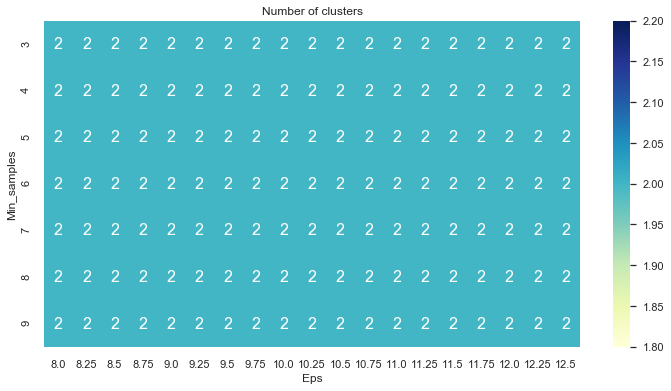

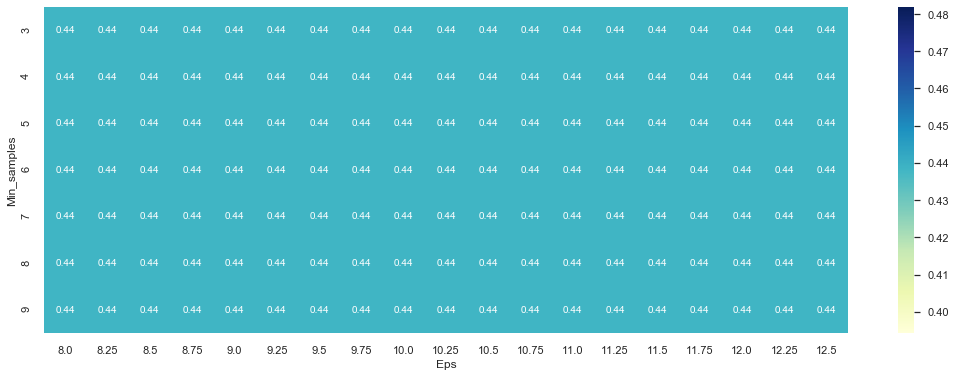

   coef_silh  score_calinski  score_davies  epsilon  Min_Sample  nbr_clusters
0   0.438165    10112.272252      0.977464      8.0           3             1
1   0.438165    10112.272252      0.977464      8.0           4             1
2   0.438165    10112.272252      0.977464      8.0           5             1
3   0.438165    10112.272252      0.977464      8.0           6             1
4   0.438165    10112.272252      0.977464      8.0           7             1


In [512]:
#def preporcessing_dbscan(data):
# Step 1: Echantillonage
#dataset= echantillon(data)
df_1, df_2, df_3, df_4, df_5= split_data(data_cluster)

# Step 2: Imputer 
imputed_data= imput_val_quantitatives(df_1)

# step 2 normalization
data_normal=nomalize(imputed_data)
# step 3: plot pca 
#data_normal= PCA_(data_normal)

# Step 4: Best Epsilon
#Eps= Epsilon(cluster_df)

# step 4: Kmeans

dataframe_iter= dbscan_grid_search(data_normal)
print(dataframe_iter.head())

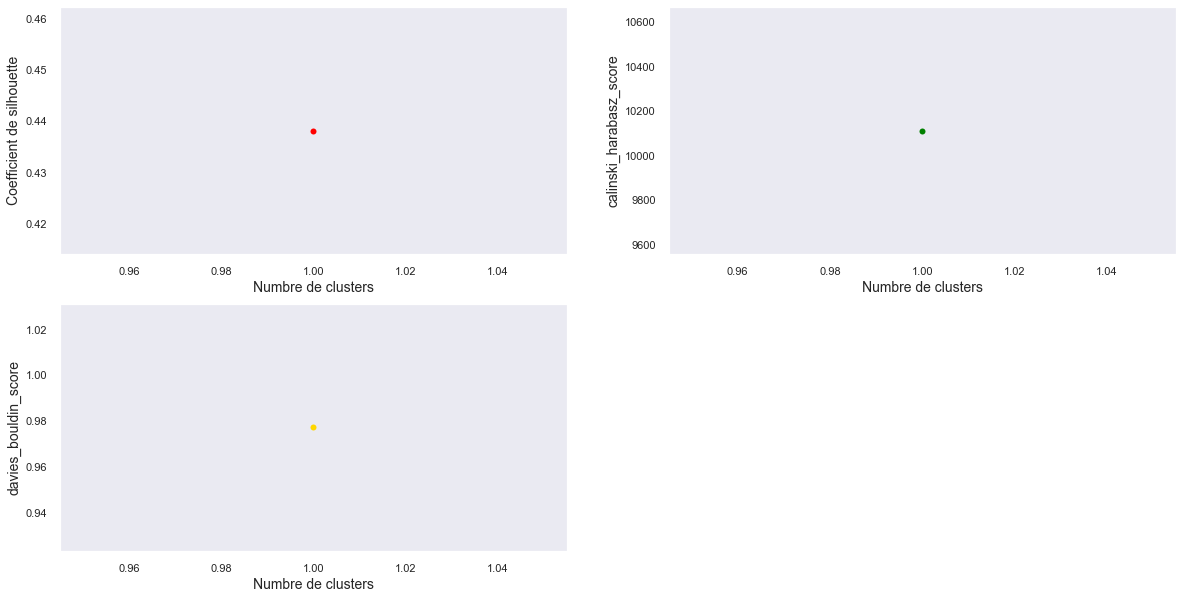

In [513]:
# plot results
plot_results_dbscan(dataframe_iter)

In [514]:
# step 6: La meilleure itération 
best_hyperparamètres= best_hyperparam(dataframe_iter)
print("best_hyperparamètres: ",best_hyperparamètres)

le meilleurs score est:       coef_silh  score_calinski  score_davies  epsilon  Min_Sample  \
0     0.438165    10112.272252      0.977464      8.0           3   
1     0.438165    10112.272252      0.977464      8.0           4   
2     0.438165    10112.272252      0.977464      8.0           5   
3     0.438165    10112.272252      0.977464      8.0           6   
4     0.438165    10112.272252      0.977464      8.0           7   
..         ...             ...           ...      ...         ...   
128   0.438165    10112.272252      0.977464     12.5           5   
129   0.438165    10112.272252      0.977464     12.5           6   
130   0.438165    10112.272252      0.977464     12.5           7   
131   0.438165    10112.272252      0.977464     12.5           8   
132   0.438165    10112.272252      0.977464     12.5           9   

     nbr_clusters  
0               1  
1               1  
2               1  
3               1  
4               1  
..            ...  
128   

In [520]:
best_hyperprm_dbscan= new_best_hyperparam_dbscan(dataframe_iter,10, 9)

le meilleurs score est:      coef_silh  score_calinski  score_davies  epsilon  Min_Sample  nbr_clusters
62   0.438165    10112.272252      0.977464     10.0         9.0           1.0


C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



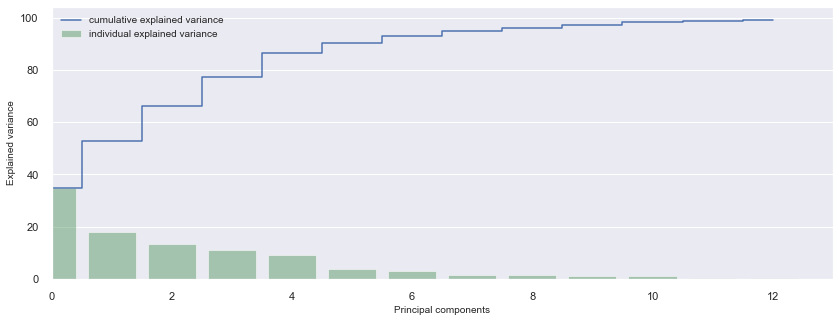

In [521]:
# step 3: plot pca 
data_normal= PCA_(data_normal)

Estimated number of clusters: 2
Estimated number of noise points: 0
Silhouette Coefficient: 0.441
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.094s...
[t-SNE] Computed neighbors for 20000 samples in 3.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed con

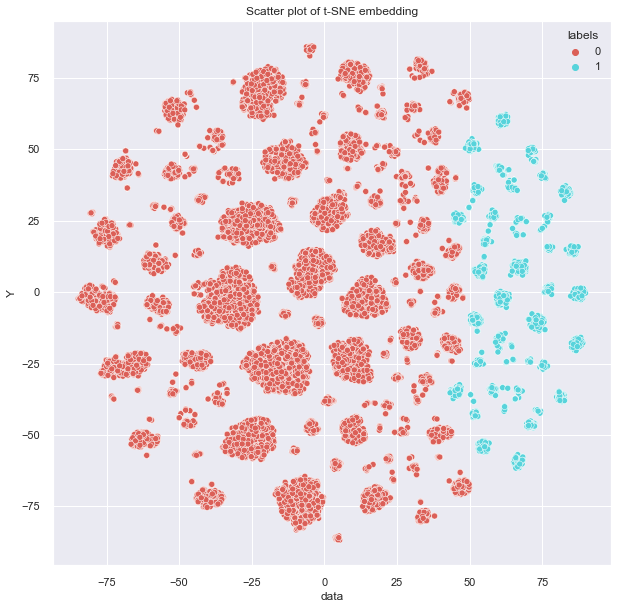

In [522]:
# step 8: fit le kmeans avec les meilleurs hypr_paramètres  
data_normal['labels']= best_dbscan(data_normal, best_hyperprm_dbscan)[0]
# step 9: plot the TSNE 
TSNE_(data_normal)

# AgglomerativeClustering:
- Ce mécanisme de clustering trouve les points de données les plus proches les uns des autres et les regroupe successivement. Le principal hyperparamètre de ce mécanisme est:
- n_clusters (le nombre de clusters que vous voulez) - les données sont fusionnées successivement, un à la fois, jusqu'à ce qu'il reste n clusters

- Le clustering agglomératif est hiérarchique car il effectue des opérations de manière séquentielle. Cet algorithme est utile dans les cas où on souhaite prendre des décisions sur la façon dont on souhaite regrouper nos données de manière grossière ou fine, ou dans quelle résolution on veut pour nos données.

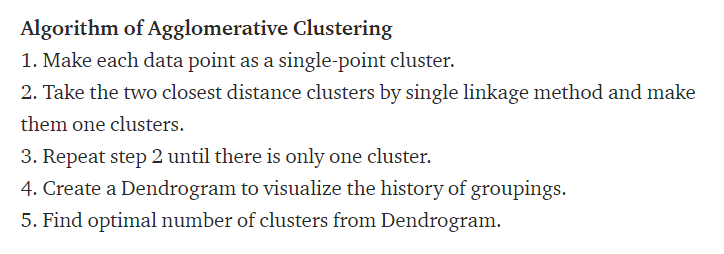

In [529]:
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram

In [530]:
#define dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
  
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
     # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [539]:
def best_hyperparam_AC(data):
    
    best_ = data.where(data["nbr_clusters"] == data["nbr_clusters"].max())
    best_.dropna(how="any", inplace=True)
    
    #On traite le cas où il y a plusieurs solutions possibles
    if best_.shape[0] > 0:
        best_ = best_.iloc[0, :]
        
    print(best_)

    return best_

def new_best_hyperparam_AC(data, nbr_clusters):
    iters= data.where(data["nbr_clusters"]== nbr_clusters)
    iters.dropna(how="all", inplace=True)
    print("le meilleurs score est: ",iters)
    if iters.shape[0]>0:
        iters= iters.iloc[0,:]
        
    return iters  
    

In [532]:
def AggCluster(data, best):
    nb_clusters = int(best["nbr_clusters"])
    linkage = best["linkage"]

    model = AgglomerativeClustering(
        n_clusters=nb_clusters,
        linkage=linkage,
        affinity="euclidean")

    #On l'entraîne sur les données préparées
    model.fit(data)

    df_AggC = pd.DataFrame()
    df_AggC["labels"] = model.labels_
    df_AggC["nbr_ind"] = 0
    df_AggC = df_AggC.groupby("labels", as_index=False).count()
    print(df_AggC)
    
    return [model.labels_, df_AggC]

In [533]:
def AggClust_gridsearch(data):
    silhoutte= []
    score_cali=[]
    score_dav=[]
    clusters_result=[]
    linkage_results=[]
    AggCluster_df=pd.DataFrame()
    
    #List of algorithms
    clustering_algorithms = (
        ('Single Linkage', 'single'),
        ('Average Linkage', 'average'),
        ('Complete Linkage', 'complete'),
        ('Ward Linkage', 'ward'),
    )  

    #distance metrics
    #affinity_metrics = ['cosine', 'euclidean', 'manhattan']
    n_clusters= range(3, 15)
    #apply the algorithm 
    for n_cluster in n_clusters: 
        for alg_name, alg in clustering_algorithms:
            #if alg == 'ward' and metric != 'euclidean': continue
            model = cluster.AgglomerativeClustering(linkage=alg,
                                                    affinity='euclidean', 
                                                    n_clusters=n_cluster)

            model.fit(data)
            
            predictions = model.fit_predict(data)
            silh = metrics.silhouette_score(data, model.labels_)
            score_dpscan_c = calinski_harabasz_score(data, model.labels_)
            score_dbsacn_d = davies_bouldin_score(data, predictions)

            silhoutte.append(silh)
            score_cali.append(score_dpscan_c)
            score_dav.append(score_dbsacn_d)
            #dispersion.append(disp)
            clusters_result.append(n_cluster)
            linkage_results.append(alg)
            
            #plt.title('Hierarchical Clustering Dendrogram: ' + alg_name )
   
    AggCluster_df["coef_silh"] = silhoutte
    AggCluster_df["nbr_clusters"] = clusters_result
    #df_iter_cah["n_init"] = result_ninit
    AggCluster_df["linkage"] = linkage_results
    AggCluster_df["score_calinski"]= score_cali
    AggCluster_df["score_davies"]= score_dav
    
    return AggCluster_df

In [534]:
#def preporcessing_AggCluster(data):
# Step 1: Echantillonage
#dataset= echantillon(data)
df_1, df_2, df_3, df_4, df_5= split_data(data_cluster)

# Step 2: Imputer 
imputed_data= imput_val_quantitatives(df_1)

# step 2 normalization
data_normal=nomalize(imputed_data)

Shape of new dataframes - (20000, 21) , (20000, 21),(20000, 21) , (20000, 21),(12062, 21) 


C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



   coef_silh  nbr_clusters   linkage  score_calinski  score_davies
0   0.414664             3    single     5119.628818      0.825717
1   0.305596             3   average     5121.563556      0.905998
2   0.251803             3  complete     8759.919659      1.484222
3   0.239394             3      ward     8398.477751      1.539876
4   0.395379             4    single     3414.263211      0.766519


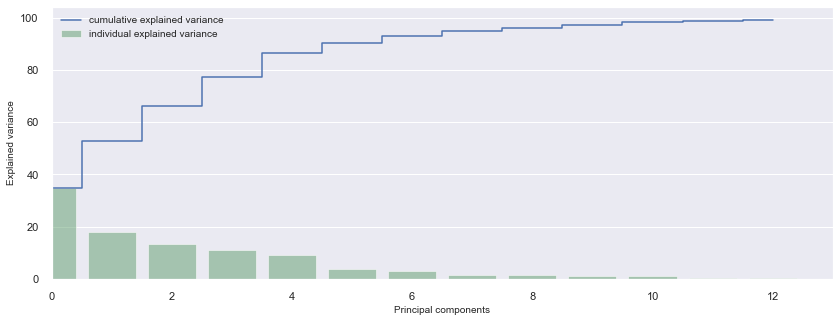

In [535]:
# step 3: plot pca 
data_normal= PCA_(data_normal)

# step 4: Kmeans

dataframe_iter= AggClust_gridsearch(data_normal)
print(dataframe_iter.head())


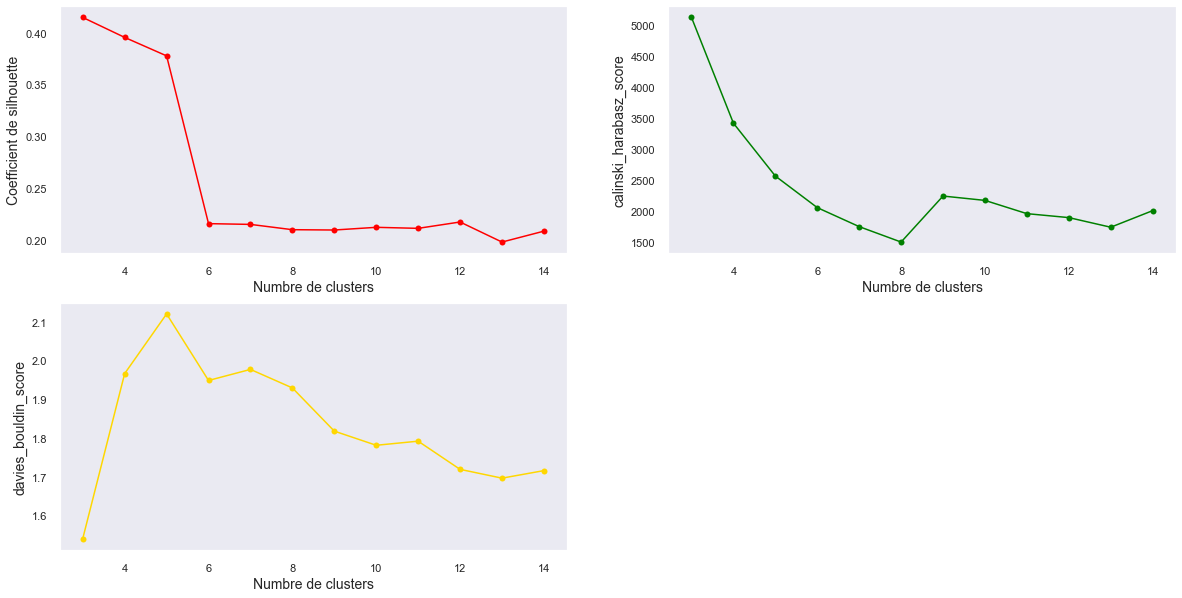

In [536]:
# plot results
#plot_results_(dataframe_iter)
plot_results_dbscan(dataframe_iter)

In [538]:
# step 6: La meilleure itération 
best_hyperparamètres= best_hyperparam_AC(dataframe_iter)
print("best_hyperparamètres: ",best_hyperparamètres)

coef_silh         0.208356
nbr_clusters            14
linkage             single
score_calinski     2390.45
score_davies       1.18952
Name: 44, dtype: object
best_hyperparamètres:  coef_silh         0.208356
nbr_clusters            14
linkage             single
score_calinski     2390.45
score_davies       1.18952
Name: 44, dtype: object


In [540]:
new_best_hyperparam_AC= new_best_hyperparam_AC(dataframe_iter, 6)

le meilleurs score est:      coef_silh  nbr_clusters   linkage  score_calinski  score_davies
12   0.215609           6.0    single     3512.247883      1.034744
13   0.127379           6.0   average     2052.060520      0.810037
14   0.156664           6.0  complete     4263.146628      1.947964
15   0.194680           6.0      ward     4971.479778      1.874866


C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



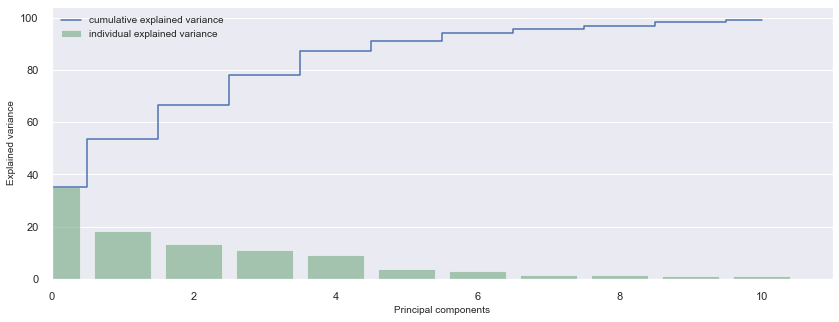

In [541]:
# step 3: plot pca 
data_normal= PCA_(data_normal)

   labels  nbr_ind
0       0     1362
1       1     7552
2       2     1635
3       3        1
4       4     9449
5       5        1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.078s...
[t-SNE] Computed neighbors for 20000 samples in 2.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample

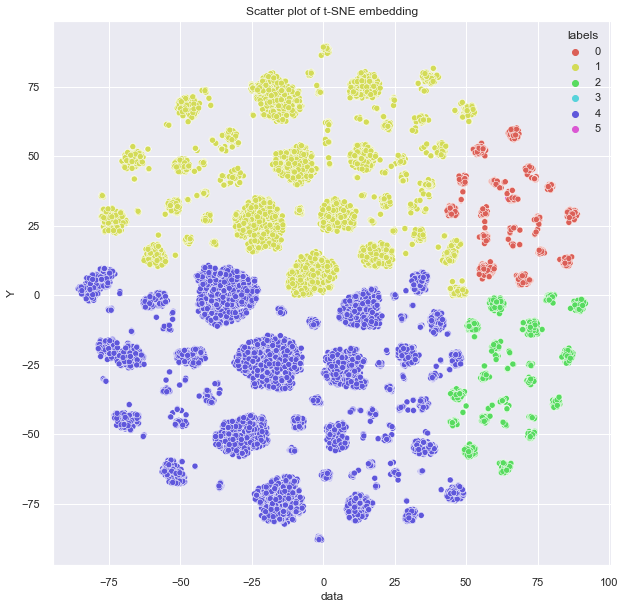

In [542]:
# step 8: fit le kmeans avec les meilleurs hypr_paramètres  
data_normal['labels']= AggCluster(data_normal, new_best_hyperparam_AC)[0]
# step 9: plot the TSNE 
TSNE_(data_normal)

# Etude de stabilité temporelle avec le k_means: 

In [213]:
from time import time
from sklearn import metrics


def bench_k_means(kmeans, name, data, labels):
 
    t0 = time()
    estimator = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator.inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator.labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))
    
    return estimator.labels_

# Fit sur df_2 et metrics sur df_1

In [221]:
df_1= data_normal.drop('labels', axis=1)
labels=data_normal['labels']


In [222]:
nbr_clusters=int(best_hyperparamètres['nbr_clusters'])
n_init= int(best_hyperparamètres['n_init'])
type_init= best_hyperparamètres['type_init']
#random_state= int(best_hyperparamètres['random_state'])


# step 2 normalization
df_2=nomalize(df_2)
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=nbr_clusters, n_init=n_init, random_state=1)

brench_data_1= bench_k_means(kmeans=kmeans, name=type_init, data=df_2, labels=labels)


kmeans = KMeans(init="random", n_clusters=nbr_clusters, n_init=n_init, random_state=1)
brench_data_2= bench_k_means(kmeans=kmeans, name="random", data=df_2, labels=labels)

#pca = PCA(0.99).fit(df_2)
#kmeans = KMeans(init=pca.components_, n_clusters=nbr_clusters, n_init=n_init)
#brench_data_3= bench_k_means(kmeans=kmeans, name="PCA-based", data=df_2, labels=labels)

print(82 * '_')



__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.156s	41053	0.001	0.001	0.001	0.000	0.000	0.471
random   	0.175s	41052	0.001	0.001	0.001	0.000	0.000	0.488
__________________________________________________________________________________


C:\Users\PC\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


k-means++	0.123s	41052	0.001	0.001	0.001	0.000	0.000	0.682
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.046s...
[t-SNE] Computed neighbors for 20000 samples in 0.662s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000

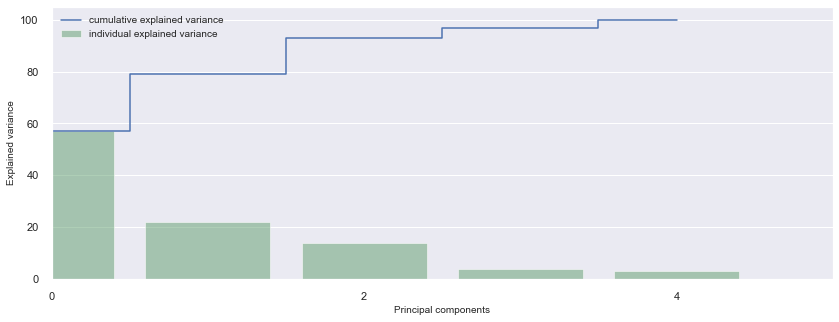

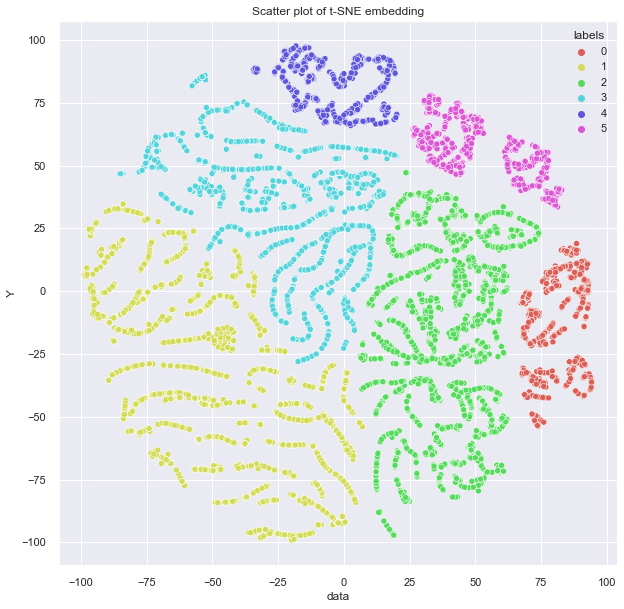

In [224]:
# Avec la PCA 
# step 1: plot pca 
df_2= PCA_(df_2)
# step 2: fit le kmeans avec les meilleurs hypr_paramètres  
kmeans = KMeans(init="k-means++", n_clusters=nbr_clusters, n_init=n_init, random_state=1)
df_2['labels']= bench_k_means(kmeans=kmeans, name=type_init, data=df_2, labels=labels)
# step 3: plot the TSNE 
TSNE_(df_2)